# This notebook generates pi0 plots for specific set of pickles

In [64]:
%matplotlib inline
import platform
print(platform.python_version())
from ROOT import TFile,vector
import ROOT

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import math


import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

3.5.2


In [65]:
# davios functions for plotting...
  
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from scipy.interpolate import interp1d
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import copy

def Tune1(df):
    return df['xsec_tune1_weight'].values

def CV(df):
    wgt = df['xsec_corr_weight'].values
    if False:
#     if 'new_weight' in df.columns:
        tmpweights1 = df['new_weight'].values

    else:
        tmpweights1 = []
        for i in range(len(wgt)):
            tmpweights1.append(1.0)
    
    if 'pot_weight' in df.columns:
        tmpweights2 = df['pot_weight'].values
    else:
        tmpweights2 = []
        for i in range(len(wgt)):
            tmpweights2.append(1.0)
            
    for i in range(len(wgt)):
        wgt[i] = wgt[i]*tmpweights1[i]*tmpweights2[i]
        
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    
    return wgt

def Spline(df):
    wgt = df['spline_weight'].values
    wgt[wgt == np.inf] = 1
    wgt = np.nan_to_num(wgt)
    wgt[wgt <= 0] = 1
    return wgt


class sampHist:

    def __init__(self,samp_df,samp_l,samp_c,samp_wind,samp_s):
        self._df = samp_df.copy()
        self._label = samp_l
        self._color = samp_c
        self._scale = samp_s
        self._wi = samp_wind
        if samp_wind == 0:
            self._wgt = np.ones(len(samp_df))
        if samp_wind == 1:
            self._wgt = CV(samp_df)

    def setweight(self,windex):
        if windex == 0:
            self._wgt = np.ones(len(self._df))
        if windex == 1:
            self._wgt = CV(self._df)

    def dist(self,s_var):
        return self._df[s_var].values

    def cosdist(self,s_var):
        return np.cos(self._df[s_var].values)

    def applycut(self,s_cut):
        newhist = copy.deepcopy(self)
        newhist._df = self._df.query(s_cut)
        newhist.setweight(self._wi)
        return newhist

class SimpleHisto:

    def __init__ (self,df_df,f_scale,i_wgt,s_color,s_label):
        temp_df = df_df.copy()
        temp_df['myscale'] = f_scale
        self.mydf = temp_df
        self.mycolor = s_color
        self.mylabel = s_label
        self.iwgt = i_wgt

        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def GetHist(self,s_varname):
        temp_df = self.mydf.query(self.mycut)
        if self.iwgt == 1:
            myweight = CV(temp_df)
        elif self.iwgt == 0:
            myweight = np.ones(len(temp_df))
        return temp_df[s_varname].values,myweight,temp_df['myscale'].values,self.mycolor,self.mylabel

def GetErrorsData(xobs,CL=0.6827):
    step    = 0.01
    upperBoundary = int(max(10,xobs+5*np.sqrt(xobs)))
    r = np.arange(0.01,upperBoundary,step)
    s    = PmuGivenX(r,xobs)*step
    PDF1 = interp1d(r,s,bounds_error=False,fill_value=0)
    PPF1 = interp1d(np.cumsum(s),r)
    xobs_low  = float(PPF1((1-CL)/2))
    xobs_high = float(PPF1(1-(1-CL)/2))
    return xobs_low,xobs_high

class StackedHisto:

    def  __init__ (self,a_df_mc,a_df_scale):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layeriwgt = []
        self.stratxweight = []

        temp_a_df = []
        for i in range(len(a_df_mc)):
            temp_df = a_df_mc[i].copy()
            temp_df['myscale'] = a_df_scale[i]
            temp_a_df.append(temp_df)
        self.mymc = pd.concat(temp_a_df)
        self.mycut ='_pi0mass >0'


    def ClearCut(self):
        self.mycut = 'Enu_1m1p > 0'

    def AddCut(self,s_cut):
        self.mycut  = s_cut

    def AddLayer(self,df_layer,df_scale,i_wgt,s_label,s_color):
        temp_df = df_layer.copy()
        temp_df['myscale'] = df_scale
        self.mylayer.append(temp_df)
        self.layerlabel.append(s_label)
        self.layercolor.append(s_color)
        self.layeriwgt.append(i_wgt)

    def AddStrata(self,s_strata,s_label,s_color,f_wgt=1.0):
        self.mystrata.append(s_strata)
        self.stratalabel.append(s_label)
        self.stratacolor.append(s_color)
        self.stratxweight.append(f_wgt)

    def GetHists(self,s_varname):
        a_vals = []        # (nxN)
        a_wgts = []
        a_scale = []
        a_cols = []        # (nx1)
        a_labels = []

        # first, run  through strata
        for i in range(len(self.mystrata)):
            # isolate this stratum with current cut
            temp_df = self.mymc.query(self.mystrata[i]+' and '+self.mycut)

            a_vals.append(temp_df[s_varname].values)
            a_wgts.append(CV(temp_df) * self.stratxweight[i])   # ah, this is if we want to scale an individual stratum
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.stratacolor[i])
            a_labels.append(self.stratalabel[i])

        for i in range(len(self.mylayer)):
            temp_df = self.mylayer[i].query(self.mycut)

            a_vals.append(temp_df[s_varname].values)
            if self.layeriwgt[i] == 1:
                a_wgts.append(CV(temp_df))
            elif self.layeriwgt[i] == 0:
                a_wgts.append(np.ones(len(temp_df)))
            a_scale.append(temp_df['myscale'].values)

            a_cols.append(self.layercolor[i])
            a_labels.append(self.layerlabel[i])

        return  np.asarray(a_vals),np.asarray(a_wgts),np.asarray(a_scale),a_cols,a_labels

    def ClearLayers(self):
        self.mylayer = []
        self.layerlabel = []
        self.layercolor = []
        self.layerwgt = []

    def ClearStrata(self):
        self.mystrata = []
        self.stratalabel = []
        self.stratacolor = []


class distVar:

    def __init__(self,s_name,n_range,s_label='',s_cov=''):
        self.myname = s_name
        self.myrange = n_range
        self.myscov = s_cov
        if s_label == '':
            self.mylabel = s_name
        else:
            self.mylabel = s_label
            
def PmuGivenX(mu,x):

    # Returns the probability density value that the true mean is mu given that you
    # have observed x events. Actually employs a series approximation because the real formula
    # involves a very very large numerator and denominator and overflows even high precision
    # variables if your bins contain more than a few hundred events
    # Approximation is good to O(0.1%) or better at all values

    pi  = np.pi
    c   = [1.,-1./12,1./288,139./51840,-571./2488320,-163879./209018880]

    if x == 0:
        return np.exp(-mu)
    else:
        poly = sum(c[i]/x**(i+0.5) for i in range(len(c)))
        return 1/np.sqrt(2*pi)*np.exp(x+x*np.log(mu/x)-mu)*poly


def distplot_wratio_davio(myvar,nbins,myrange,stackedhists,datahist,stxcoord,m_cov,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #consFac is new and consolidates all MC strata whose contribution is less than a given percent threshold.
    # (my legend was too full of useless stuff)

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    data_vals,data_wgt,data_scale,_,data_label = datahist.GetHist(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


    vals_data_raw,_ = np.histogram(data_vals,nbins,range=myrange,weights=data_wgt)
    vals_data,_ = np.histogram(data_vals,nbins,range=myrange,weights=np.multiply(data_wgt,data_scale))
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    #jarretbars
    a_obslo = []
    a_obshi = []
    for i in range(nbins):
        obslo,obshi = GetErrorsData(vals_data[i])
        a_obshi.append(obshi-vals_data[i])
        a_obslo.append(vals_data[i]-obslo)

    #m_cov is fractional, so we multiply it by MC
    for i in range(nbins):
        for j in range(nbins):
            if(vals_mc[i] > 0 and vals_mc[j] > 0):
                m_cov[i][j] *= vals_mc[i]*vals_mc[j]
#             else if math.isnan(vals_mc[i]) or math.isnan(vals_mc[j]):
#                 m_cov[i][j] = 0
            else:
                m_cov[i][j] = 0
#             else:
#                 print("uh oh!",vals_mc[i],vals_mc[j] )

    # Normalization uncertainty:
    for i in range(len(m_cov)):
        for j in range(len(m_cov[i])):
            if math.isnan(m_cov[i][j]):
                m_cov[i][j]=0.0000000001
                
    fNorm_squared = m_cov.sum() / np.power(vals_mc.sum(),2)
#     print("first", m_cov)
    print('Normalization Uncertainty:',np.sqrt(fNorm_squared))

    yerr_mc_sys = np.sqrt(np.diag(m_cov))
    yerr_mc_total = np.sqrt(np.diag(m_cov) + yerrsq_mc)

    yerrsq_data = np.zeros(nbins)
    for i in range(nbins):
        if vals_mc_raw[i] > 0:
            ndof += 1
            if vals_data[i] > 0:
                yerrsq_data[i] += (3.0*vals_data[i]*vals_mc[i]*normshift)/(vals_mc[i]*normshift+2.0*vals_data[i])
            else:
                yerrsq_data[i] += vals_mc[i]*normshift/2.0
            m_cov[i][i] += yerrsq_data[i] + yerrsq_mc[i]
        else:
            m_cov[i][i] += 999

    yerr_data = np.sqrt(yerrsq_data)

    er_rat_line = np.zeros(nbins)
    er_rat_line_sys = np.zeros(nbins)
    er_rat_dotshi = np.zeros(nbins)
    er_rat_dotslo = np.zeros(nbins)

    for i in range(nbins):
        if vals_mc[i] > 0:
            er_rat_line[i] = yerr_mc_total[i]/float(vals_mc[i])
            er_rat_line_sys[i] = yerr_mc_sys[i]/float(vals_mc[i])
            er_rat_dotshi[i] = a_obshi[i]/float(vals_mc[i])
            er_rat_dotslo[i] = a_obslo[i]/float(vals_mc[i])

    chisq = 0.0
    invcov = np.linalg.inv(m_cov)

    # calc chi2
    for i in range(nbins):
        for j in range(nbins):
            if vals_mc_raw[i] > 0 and vals_mc_raw[j] > 0:
                chisq += (vals_mc[i] - vals_data[i]) * (vals_mc[j] - vals_data[j]) * invcov[i][j]
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    print(chisq/float(ndof),pval)

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ymax = max((vals_data+np.asarray(a_obshi)).max(),(vals_mc+yerr_mc_sys).max())*1.4

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(0,2)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Event Count',fontsize=25)
    ax1.set_ylabel('Data/MC',fontsize=25)
    ax0.set_title('MCC9 Data/MC',fontsize=30)

    ax0.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax0.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax0.errorbar(bincenters,vals_data,fmt='o',yerr=(a_obslo,a_obshi),color='black',capsize=5,label=data_label+' (%i)'%vals_data.sum(),markersize=8,zorder=20,elinewidth=2)
    ax0.errorbar(bincenters,vals_data,fmt='o',color='white',zorder=19,markersize=16)

    errboxes_tot = []
    errboxes_sys = []

    for i in range(len(bincenters)):
        rect0 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_sys[i])),binedges[i+1]-binedges[i],yerr_mc_sys[i]*2)
        errboxes_sys.append(rect0)
        rect1 = Rectangle((binedges[i],(vals_mc[i]-yerr_mc_total[i])),binedges[i+1]-binedges[i],yerr_mc_total[i]*2)
        errboxes_tot.append(rect1)
    pc_sys = PatchCollection(errboxes_tot,facecolor='red', alpha=.3,hatch='X',edgecolor='white')
    pc_sys_outline = PatchCollection(errboxes_tot,facecolor='none', alpha=.9,hatch='X',edgecolor='white',zorder=11)
    pc_tot = PatchCollection(errboxes_sys,facecolor=None,alpha=.1,hatch='/',zorder=12)
    ax0.add_collection(pc_sys)
    ax0.add_collection(pc_sys_outline)
    ax0.add_collection(pc_tot)
    ax0.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0,label='MC Systematic Error')
    ax0.hist(np.zeros(1),(1,2),facecolor='red', alpha=.3,hatch='X',edgecolor='white',label='MC Sys+Stat Error')
    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    errboxes_rat_tot = []
    errboxes_rat_sys = []
    for i in range(len(er_rat_dotshi)):
        rect0 = Rectangle((binedges[i],1-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_rat_tot.append(rect0)
        rect1 = Rectangle((binedges[i],1-er_rat_line_sys[i]),binedges[i+1]-binedges[i],er_rat_line_sys[i]*2)
        errboxes_rat_sys.append(rect1)

    pc_rat_tot = PatchCollection(errboxes_rat_tot, facecolor='red', alpha=.3)
    pc_rat_sys = PatchCollection(errboxes_rat_sys, facecolor=None, alpha=.1,hatch='/',zorder=12)
    ax1.add_collection(pc_rat_tot)
    ax1.add_collection(pc_rat_sys)
    ax1.hist(np.zeros(1),(1,2),facecolor=None,alpha=.1,hatch='//',zorder=0)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0)
    ax1.errorbar(bincenters,np.true_divide(vals_data,vals_mc),yerr=(er_rat_dotshi,er_rat_dotslo),fmt='o',color='maroon',capsize=0,markersize=8,elinewidth=2)

    #ax1.legend(loc='lower right',fontsize=15,frameon=False)

    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$data/$\sum$MC = %.2f $\pm$ %.2f'%(vals_data.sum()/float(vals_mc.sum()),np.sqrt(fNorm_squared)),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))

    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2_{CNP}/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9),zorder=30)

    plt.tight_layout()

    return fig,ax0,ax1,pval

def distplot_mc(myvar,nbins,myrange,stackedhists,stxcoord,legpos=0,ymax=-1,normshift=1,fs=(16,11),consFac=0.0):

    #for plotting truth variables

    vals_mc = np.zeros(nbins)
    vals_mc_raw = np.zeros(nbins)
    yerrsq_mc = np.zeros(nbins)
    yrr_mc_sys = np.zeros(nbins)
    ndof = 0

    a_labels_evts_draw = []
    a_labels_evts_failThresh = []
    a_cols_draw = []
    a_vals_draw = []
    a_wgts_draw = []
    a_vals_failThresh = []
    a_wgts_failThresh = []
    evts_failThresh = 0.0

    gh_vals,gh_wgts,gh_scale,gh_cols,gh_labels = stackedhists.GetHists(myvar)
    print("hstack gh_weights",np.hstack(gh_wgts))
    print("hstack gh_scale",np.hstack(gh_scale))
    vals_mc_total,binedges = np.histogram(np.hstack(gh_vals),nbins,range=myrange,weights=np.hstack(gh_wgts)*np.hstack(gh_scale))
    mctot = vals_mc_total.sum()
    mcthresh = consFac * mctot


    for i in range(len(gh_vals)):
        h1_raw,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i])     # hist of raw event weights
        h1,_ = np.histogram(gh_vals[i],nbins,range=myrange,weights=gh_wgts[i]*gh_scale[i])

        vals_mc_raw += h1_raw
        vals_mc += h1

        scalesort = gh_scale[i].argsort()
        sorted_vals = gh_vals[i][scalesort[::-1]]
        sorted_scale = gh_scale[i][scalesort[::-1]]
        sorted_wgt = gh_wgts[i][scalesort[::-1]]
        for sc in np.unique(sorted_scale):
            subvals = sorted_vals[sorted_scale==sc]
            subwgts = sorted_wgt[sorted_scale==sc]
            subh1,_ = np.histogram(subvals,nbins,range=myrange,weights=subwgts)
            yerrsq_mc += np.power(np.sqrt(subh1)*sc,2)
       
        a_vals_draw.append(gh_vals[i].copy())
        a_wgts_draw.append((gh_wgts[i]*gh_scale[i]).copy())
        a_labels_evts_draw.append(gh_labels[i]+' (%.2f)'%h1.sum())
        a_cols_draw.append(gh_cols[i])


   
  

   

    fig,ax = plt.subplots(figsize=fs)

    ymax = (vals_mc).max()*1.4

    ax.set_ylim(0,ymax)
    ax.set_xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Event Count',fontsize=25)
    ax.set_title('MCC9 MC',fontsize=30)

    ax.hist(a_vals_draw,nbins,range=myrange,weights=a_wgts_draw,color=a_cols_draw,stacked=True,linewidth=0,label=a_labels_evts_draw,edgecolor=None)
    ax.hist(np.hstack(a_vals_draw),nbins,range=myrange,weights=np.hstack(a_wgts_draw),histtype='step',zorder=20,color='black',linewidth=2)

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=2)

    
    plt.tight_layout()

    return fig,ax

In [66]:
NUMU_R1_POT = 4.71579e+20
NUMU_R1_1MIL_POT = 1.33678E+21
NUE_R1_POT  = 9.80259e+22

DETVAR_CV_POT =  9.65858292241e+19

NUMU_R3_POT = 8.98773223801e+20
NUE_R3_POT = 4.707047e+22

NUMU_R2_POT = 4.08963968669e+20
NUE_R2_POT = 9.2085012316e+22

CCPI0_R1_POT = 6.95344e+20
CCPI0_R3_POT = 5.92213e+20
NCPI0_R1_POT = 2.90401e+21
NCPI0_R3a_POT = 2.62745e+20
NCPI0_R3b_POT = 2.22482e+21

DATA_R1_OPEN_POT = 4.403e+19
DATA_R3_OPEN_POT = 8.786e+18
DATA_R1_PI0FILTER_POT =1.746e+20
DATA_R2D_PI0FILTER_POT = 2.050e+20
DATA_R2E_PI0FILTER_POT = 6.507e+19
DATA_R3F_PI0FILTER_POT = 4.3e+19
DATA_R3G_PI0FILTER_POT = 2e+20

FAKE_DATA_1_RUN1_POT = 1.925e20
FAKE_DATA_1_RUN3_POT = 2.83e20

EXT_R1_PI0FILTER_POT = 22474918.0/41898673.0 * DATA_R1_PI0FILTER_POT 
EXT_R1_OPEN_POT = 22474918.0 / 9776965.0* DATA_R1_OPEN_POT
EXT_R1_FAKE1_POT = 22474918.0 /41898673.0* FAKE_DATA_1_RUN1_POT

EXT_R2D_PI0FILTER_POT =  39566274.0/49422124.0 * DATA_R2D_PI0FILTER_POT
EXT_R2E_PI0FILTER_POT =  39566274.0/19914275.0 * DATA_R2E_PI0FILTER_POT
EXT_R3F_PI0FILTER_POT =  39566274.0/11229268.0 * DATA_R3F_PI0FILTER_POT
EXT_R3G_PI0FILTER_POT =  39566274.0/51705212.0 * DATA_R3G_PI0FILTER_POT
EXT_R3_OPEN_POT = 39566274.0/2263559.0 * DATA_R3_OPEN_POT
EXT_R3_FAKE1_POT = 39566274.0/11229268.0 * FAKE_DATA_1_RUN3_POT

POT_SCALE_FACTOR = 1.0 #if I feel like playing with scaling
# CURRENT TOTAL
DATA_POT_TOTAL = DATA_R1_PI0FILTER_POT+DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT
print("total POT: ",DATA_POT_TOTAL)
print("1", EXT_R1_PI0FILTER_POT)
print("2", EXT_R2E_PI0FILTER_POT+EXT_R2D_PI0FILTER_POT)
print("3", EXT_R3G_PI0FILTER_POT+EXT_R3F_PI0FILTER_POT)

total POT:  6.8767e+20
1 9.365739776054483e+19
2 2.9340153832119832e+20
3 3.045558940373219e+20


In [67]:
NUMU_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NUMU_R1_POT)
NUE_R1_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NUE_R1_POT)
EXT_R1_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(EXT_R1_OPEN_POT)
CCPI0_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(CCPI0_R1_POT)
NCPI0_R1_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R1_OPEN_POT)/ float(NCPI0_R1_POT)


NUMU_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUMU_R1_POT)
NUMU_R1_1MIL_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUMU_R1_1MIL_POT)
NUE_R1_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NUE_R1_POT)
EXT_R1_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(EXT_R1_PI0FILTER_POT)
CCPI0_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(CCPI0_R1_POT)
NCPI0_R1_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R1_PI0FILTER_POT)/ float(NCPI0_R1_POT)

NUMU_R1_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUMU_R1_POT)
NUE_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(NUE_R1_POT)
EXT_R1_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN1_POT)/ float(EXT_R1_FAKE1_POT)

NUMU_R2D_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(NUMU_R2_POT)
NUE_R2D_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(NUE_R2_POT)
EXT_R2D_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2D_PI0FILTER_POT)/ float(EXT_R2D_PI0FILTER_POT)
NUMU_R2E_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(NUMU_R2_POT)
NUE_R2E_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(NUE_R2_POT)
EXT_R2E_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R2E_PI0FILTER_POT)/ float(EXT_R2E_PI0FILTER_POT)

NUMU_R3_OPEN_SCALE = (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(NUMU_R3_POT)
NUE_R3_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(NUE_R3_POT)
EXT_R3_OPEN_SCALE =  (POT_SCALE_FACTOR*DATA_R3_OPEN_POT)/ float(EXT_R3_OPEN_POT)
NUMU_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(NUMU_R3_POT)
NUE_R3F_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(NUE_R3_POT)
EXT_R3F_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3F_PI0FILTER_POT)/ float(EXT_R3F_PI0FILTER_POT)
NUMU_R3_FAKE1_SCALE = (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUMU_R3_POT)
NUE_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(NUE_R3_POT)
EXT_R3_FAKE1_SCALE =  (POT_SCALE_FACTOR*FAKE_DATA_1_RUN3_POT)/ float(EXT_R3_FAKE1_POT)
NUMU_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(NUMU_R3_POT)
NUE_R3G_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(NUE_R3_POT)
EXT_R3G_PI0FILTER_SCALE =  (POT_SCALE_FACTOR*DATA_R3G_PI0FILTER_POT)/ float(EXT_R3G_PI0FILTER_POT)

CCPI0_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3F_PI0FILTER_POT))/ float(CCPI0_R3_POT)
NCPI0_R3F_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3F_PI0FILTER_POT))/ float(NCPI0_R3a_POT+NCPI0_R3b_POT)
CCPI0_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3G_PI0FILTER_POT))/ float(CCPI0_R3_POT)
NCPI0_R3G_PI0FILTER_SCALE = (POT_SCALE_FACTOR*(DATA_R3G_PI0FILTER_POT))/ float(NCPI0_R3a_POT+NCPI0_R3b_POT)


NUMU_R3_DETVAR_SCALE = (DETVAR_CV_POT)/ float(NUMU_R3_POT)

In [68]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?

tag = 'Nov_20_run1_numu'
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Feb_4_run1_numu'
df_numu_1mil_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_nue'
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run1_ext'
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)
tag ='Nov_20_open_run1'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run2_numu'
df_numu_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run2_nue'
df_nue_r2_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)

tag = 'Nov_20_run3_numu'
df_numu_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_nue'
df_nue_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_run3_ext'
df_ext_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_precuts_%s.pickle'%tag)

tag = 'Jan_15_run1_CCPi0'
df_ccpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
print("all events: ", len(df_ccpi0_r1_goodruns_pmtprecut))
print(" haspi0 events: ", len(df_ccpi0_r1_goodruns_pmtprecut.query("haspi0==1")))
tag = 'Jan_15_run3_CCPi0'
df_ccpi0_r3_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run1_NCPi0'
df_ncpi0_r1_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3a_NCPi0'
df_ncpi0_r3a_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
tag = 'Jan_15_run3b_NCPi0'
df_ncpi0_r3b_goodruns_pmtprecut = pd.read_pickle('../data/pickles/%s.pickle'%tag)
# combine r3a,r3b files
df_ncpi0_r3_goodruns_pmtprecut = df_ncpi0_r3a_goodruns_pmtprecut.append(df_ncpi0_r3b_goodruns_pmtprecut)

ccpi0r1pi0=np.ones(len(df_ccpi0_r1_goodruns_pmtprecut))
df_ccpi0_r1_goodruns_pmtprecut["newhaspi0"] = ccpi0r1pi0
ccpi0r3pi0=np.ones(len(df_ccpi0_r3_goodruns_pmtprecut))
df_ccpi0_r3_goodruns_pmtprecut["newhaspi0"] = ccpi0r3pi0

ncpi0r1pi0=np.ones(len(df_ncpi0_r1_goodruns_pmtprecut))
df_ncpi0_r1_goodruns_pmtprecut["newhaspi0"] = ncpi0r1pi0
ncpi0r3pi0=np.ones(len(df_ncpi0_r3_goodruns_pmtprecut))
df_ncpi0_r3_goodruns_pmtprecut["newhaspi0"] = ncpi0r3pi0

tag = 'Nov_20_pi0box_run1'
df_data_r1_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_pi0box_run2D'
df_data_r2D_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_pi0box_run2E'
df_data_r2E_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_pi0box_run3F'
df_data_r3F_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)
tag = 'Nov_20_pi0box_run3G'
df_data_r3G_pi0filter_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_precuts_%s.pickle'%tag)


all events:  3307
 haspi0 events:  3307


In [69]:
# start with classic pi0 cuts on each df
precuts= 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and NTracks ==2 and _pi0mass>0 and _pi0mass<400 and Proton_Edep>60.0  and Electron_Edep>35.0'
# cut on new shower variables separately
cuts_new = 'good ==1 and PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'
# cuts_new=precuts
cuts_2 = 'PassPMTPrecut ==1 and PassShowerReco ==1 and InFiducial ==1 and _pi0mass_new<400 and DeltaMass_new >0 and DeltaMass_new <1400 and NTracks ==2 and Proton_Edep>60.0  and Electron_Edep>35.0  and shower1_E_Y_new>80 and ChargeNearTrunk >250 and Electron_ThetaRecoB_e1ep <1.5 and _shower_alpha <2.5 and _pi0mass_new>0 and BDTscore_1e1p<.7'

RSE = ['run','subrun','event']
sort = 'shower1_E_Y'

# precuts for open run 1 test
df_numu_pre = df_numu_goodruns_pmtprecut.query(precuts+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pre = df_numu_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_pre = df_nue_goodruns_pmtprecut.query(precuts+ ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pre = df_nue_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_pre = df_ext_goodruns_pmtprecut.query(precuts)
df_ext_pre = df_ext_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r1_open_pre = df_data_goodruns_pmtprecut.query(precuts)
df_data_r1_open_pre = df_data_r1_open_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_data_r1_open_pre)/len(df_numu_pre))


df_ccpi0_r1_pre = df_ccpi0_r1_goodruns_pmtprecut.query(precuts)
df_ccpi0_r1_pre = df_ccpi0_r1_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pre = df_ncpi0_r1_goodruns_pmtprecut.query(precuts)
df_ncpi0_r1_pre = df_ncpi0_r1_pre.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

# now apply cuts
df_numu_pi0 = df_numu_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_pi0 = df_numu_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_numu_1mil_pi0 = df_numu_1mil_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_1mil_pi0 = df_numu_1mil_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(df_numu_goodruns_pmtprecut['xsec_corr_weight'].values)
df_nue_pi0 = df_nue_goodruns_pmtprecut.query(cuts_new + ' and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_pi0 = df_nue_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_pi0 = df_ext_goodruns_pmtprecut.query(cuts_new)
df_ext_pi0 = df_ext_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r1_open_pi0 = df_data_goodruns_pmtprecut.query(cuts_new)
df_data_r1_open_pi0 = df_data_r1_open_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_data_r1_open_pi0)/len(df_numu_pi0))

df_numu_r2_pi0 = df_numu_r2_goodruns_pmtprecut.query(cuts_new + 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r2_pi0 = df_numu_r2_pi0.sort_values(sort,ascending=False).drop_duplicates('CVIndex').sort_index()
df_nue_r2_pi0 = df_nue_r2_goodruns_pmtprecut.query(cuts_new)
df_nue_r2_pi0 = df_nue_r2_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print(len(df_nue_r2_pi0))

df_numu_r3_pi0 = df_numu_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==12)')
df_numu_r3_pi0 = df_numu_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_nue_r3_pi0 = df_nue_r3_goodruns_pmtprecut.query(cuts_new+ 'and not (nu_interaction_ccnc==0 and abs(nu_pdg)==14)')
df_nue_r3_pi0 = df_nue_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ext_r3_pi0 = df_ext_r3_goodruns_pmtprecut.query(cuts_new)
df_ext_r3_pi0 = df_ext_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_data_r1_pi0filter_pi0 = df_data_r1_pi0filter_pmtprecut.query(cuts_new)
df_data_r1_pi0filter_pi0 = df_data_r1_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r2D_pi0filter_pi0 = df_data_r2D_pi0filter_pmtprecut.query(cuts_new)
df_data_r2D_pi0filter_pi0 = df_data_r2D_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r2E_pi0filter_pi0 = df_data_r2E_pi0filter_pmtprecut.query(cuts_new)
df_data_r2E_pi0filter_pi0 = df_data_r2E_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r3F_pi0filter_pi0 = df_data_r3F_pi0filter_pmtprecut.query(cuts_new)
df_data_r3F_pi0filter_pi0 = df_data_r3F_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_data_r3G_pi0filter_pi0 = df_data_r3G_pi0filter_pmtprecut.query(cuts_new)
df_data_r3G_pi0filter_pi0 = df_data_r3G_pi0filter_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()

df_data_r2_pi0filter_pi0 = df_data_r2D_pi0filter_pi0.append(df_data_r2E_pi0filter_pi0)
df_data_r3_pi0filter_pi0 = df_data_r3F_pi0filter_pi0.append(df_data_r3G_pi0filter_pi0)

# mc pi0 samples
df_ccpi0_r1_pi0 = df_ccpi0_r1_goodruns_pmtprecut.query(cuts_new)
df_ccpi0_r1_pi0 = df_ccpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ccpi0_r3_pi0 = df_ccpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ccpi0_r3_pi0 = df_ccpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r1_pi0 = df_ncpi0_r1_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r1_pi0 = df_ncpi0_r1_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
df_ncpi0_r3_pi0 = df_ncpi0_r3_goodruns_pmtprecut.query(cuts_2)
df_ncpi0_r3_pi0 = df_ncpi0_r3_pi0.sort_values(sort,ascending=False).drop_duplicates(RSE).sort_index()
print("pi0 lengths: ", len(df_ccpi0_r1_pi0), len(df_ccpi0_r3_pi0), len(df_ncpi0_r1_pi0), len(df_ncpi0_r3_pi0))

0.1280952380952381
[1.         1.         1.         ... 1.17870595 1.14509094 1.53516845]
0.10013908205841446
2532
pi0 lengths:  1121 1011 1134 1174


In [70]:
# print some values
print(len(df_numu_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
print(len(df_numu_1mil_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
print(len(df_numu_r2_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
print(len(df_numu_r3_pi0.query("newhaspi0==1 and ccnc==0 and (MC_parentPDG ==14)")))
print(len(df_ccpi0_r1_pi0))
print(len(df_ccpi0_r3_pi0))
print()

print(len(df_numu_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
print(len(df_numu_1mil_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
print(len(df_numu_r2_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
print(len(df_numu_r3_pi0.query("newhaspi0==1 and ccnc==1 and (MC_parentPDG ==14)")))
print(len(df_ncpi0_r1_pi0))
print(len(df_ncpi0_r3_pi0))
print()
print(len(df_numu_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
print(len(df_numu_1mil_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
print(len(df_numu_r2_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))
print(len(df_numu_r3_pi0.query("newhaspi0==0 and (MC_parentPDG ==14)")))


# loop through original sample
for i in range(len(df_numu_pi0)):
    r_old = df_numu_pi0['run'].values[i]

866
2509
721
1517
1121
1011

204
583
186
399
1134
1174

361
1010
317
631


In [71]:
# if I want simple variables

# file1 = open("Nov9_pi0selection_bnb_overlay_run1.txt","w")
# file1.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_pi0)):
#     teststr = str(df_numu_pi0['run'].values[event])+" "+str(df_numu_pi0['subrun'].values[event])+" "+str(df_numu_pi0['event'].values[event])+" "+str(df_numu_pi0['Enu_true'].values[event])+" "+str(df_numu_pi0['haspi0'].values[event])+"\n"
#     file1.write(teststr)
# file1.close()

# file2 = open("Nov9_pi0selection_bnb_overlay_run2.txt","w")
# file2.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_r2_pi0)):
#     teststr = str(df_numu_r2_pi0['run'].values[event])+" "+str(df_numu_r2_pi0['subrun'].values[event])+" "+str(df_numu_r2_pi0['event'].values[event])+" "+str(df_numu_r2_pi0['Enu_true'].values[event])+" "+str(df_numu_r2_pi0['haspi0'].values[event])+"\n"
#     file2.write(teststr)
# file2.close()

# file3 = open("Nov9_pi0selection_bnb_overlay_run3.txt","w")
# file3.write("run subrun event Enu_true haspi0 \n")
# for event in range(len(df_numu_r3_pi0)):
#     teststr = str(df_numu_r3_pi0['run'].values[event])+" "+str(df_numu_r3_pi0['subrun'].values[event])+" "+str(df_numu_r3_pi0['event'].values[event])+" "+str(df_numu_r3_pi0['Enu_true'].values[event])+" "+str(df_numu_r3_pi0['haspi0'].values[event])+"\n"
#     file3.write(teststr)
# file3.close()

In [72]:
#  print out counts ratios
# print("data Ratios (normalized to 1e20)")
# d1 = float(len(df_data_r1_pi0filter_pi0)*(1e20/DATA_R1_PI0FILTER_POT))
# d2 = float((len(df_data_r3F_pi0filter_pi0)+len(df_data_r3G_pi0filter_pi0))*(1e20/(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)))
# d3 = float((len(df_data_r2D_pi0filter_pi0)+len(df_data_r2E_pi0filter_pi0))*(1e20/(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT))) 
# print("run1/run3: (",d1,")/(",d3,")")
# print("      = ", d1/d3 )
# print("run1/run2: (",d1,")/(",d2,")")
# print("      = ",d1/d2)
# print("run2/run3: (",d2,")/(",d3,")")
# print("      = ", d2/d3)
# print(" ")
# print("MC Ratios")
# print("run1/run3: (",len(df_numu_pi0)*(1e20/(NUMU_R1_POT)),"),(",len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT)),")")
# print("      = ", float(len(df_numu_pi0)*(1e20/(NUMU_R1_POT)))/float(len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT))))
# print("run1/run2: (",len(df_numu_pi0)*(1e20/(NUMU_R1_POT)),"),(",len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)),")")
# print("      = ", float(len(df_numu_pi0)*(1e20/(NUMU_R1_POT)))/float(len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT))))
# print("run2/run3: (",len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)),"),(",len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT)),")")
# print("      = ", float(len(df_numu_r2_pi0)*(1e20/(NUMU_R2_POT)))/float(len(df_numu_r3_pi0)*(1e20/(NUMU_R3_POT))))

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# cols = df_nue_pi0.columns.tolist()
# print("")
# print("Variables in DF:")
# print(cols)

In [73]:
#seperate out truth types

# first preselection:
# df_bnb_ncpi0_pre = df_numu_pre.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0_pre = df_numu_pre.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx_pre = df_numu_pre.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx_pre = df_numu_pre.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good_pre = df_numu_pre.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_pre = df_ncpi0_r1_pre.query('MC_scedr<5 ')
df_bnb_ccpi0_pre = df_ccpi0_r1_pre.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx_pre = df_ccpi0_r1_pre.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx_pre = df_ncpi0_r1_pre.query("MC_scedr>=5 ")
df_bnb_other_offvtx_pre = df_numu_pre.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_pre = df_numu_pre.query("haspi0==0 and MC_scedr<5")


# now all cuts
df_bnb_ncpi0 = df_ncpi0_r1_pi0.query('MC_scedr<5 ')
df_bnb_ccpi0 = df_ccpi0_r1_pi0.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx = df_ccpi0_r1_pi0.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx = df_ncpi0_r1_pi0.query("MC_scedr>=5 ") 
df_bnb_other_offvtx = df_numu_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good = df_numu_pi0.query("haspi0==0 and MC_scedr<5")


# df_bnb_ncpi0 = df_numu_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
# df_bnb_ccpi0 = df_numu_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
# df_bnb_pi0_offvtx = df_numu_pi0.query("haspi0==1 and MC_scedr>=5 ") 
# df_bnb_other_offvtx = df_numu_pi0.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good = df_numu_pi0.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_r2 = df_numu_r2_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 ')
df_bnb_ccpi0_r2 = df_numu_r2_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5") 
df_bnb_pi0_offvtx_r2 = df_numu_r2_pi0.query("haspi0==1 and MC_scedr>=5 ") 
df_bnb_other_offvtx_r2 = df_numu_r2_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_r2 = df_numu_r2_pi0.query("haspi0==0 and MC_scedr<5")

df_bnb_ncpi0_r3 = df_ncpi0_r3_pi0.query('MC_scedr<5 ')
df_bnb_ccpi0_r3 = df_ccpi0_r3_pi0.query("MC_scedr<5") 
df_bnb_ccpi0_offvtx_r3 = df_ccpi0_r3_pi0.query("MC_scedr>=5 ") 
df_bnb_ncpi0_offvtx_r3 = df_ncpi0_r3_pi0.query("MC_scedr>=5 ") 
df_bnb_other_offvtx_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr>=5 ")
df_bnb_other_good_r3 = df_numu_r3_pi0.query("haspi0==0 and MC_scedr<5")

In [74]:
# plot box cut variables at preselection.
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((0.0,400.0))
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((0.0,800.0))
bins_list.append(20)

vartest_list.append('ChargeNearTrunk')
varname_list.append('Charge within 5 cm of vertex')
myrange_list.append((0.0,1000.0))
bins_list.append(20)

vartest_list.append('Electron_ThetaRecoB_e1ep')
varname_list.append('Electron Theta (radians)')
myrange_list.append((0.0,3.2))
bins_list.append(20)

vartest_list.append('_shower_alpha')
varname_list.append('3D angle between showers (radians)')
myrange_list.append((0.0,3.2))
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('DeltaMass (MeV)')
myrange_list.append((750.0,2000))
bins_list.append(20)

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
1.2705825164834752 0.18613370690335918
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
2.2614212376221685 0.0010274094866448147
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
4.375868553122654 2.0074530926450507e-10
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
5.593035546201267 8.992806499463768e-15
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
3.006043574552385 1.76484802815179

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in true_divide


hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
3.565803178165078 8.304376715173589e-07


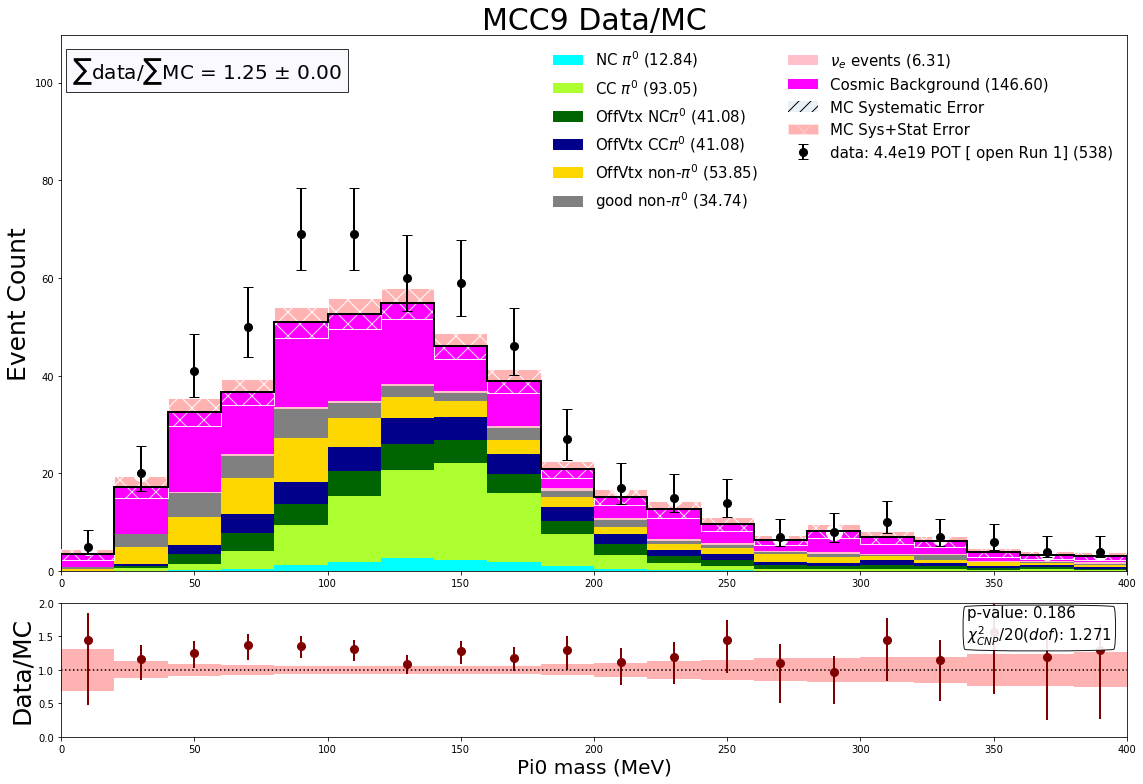

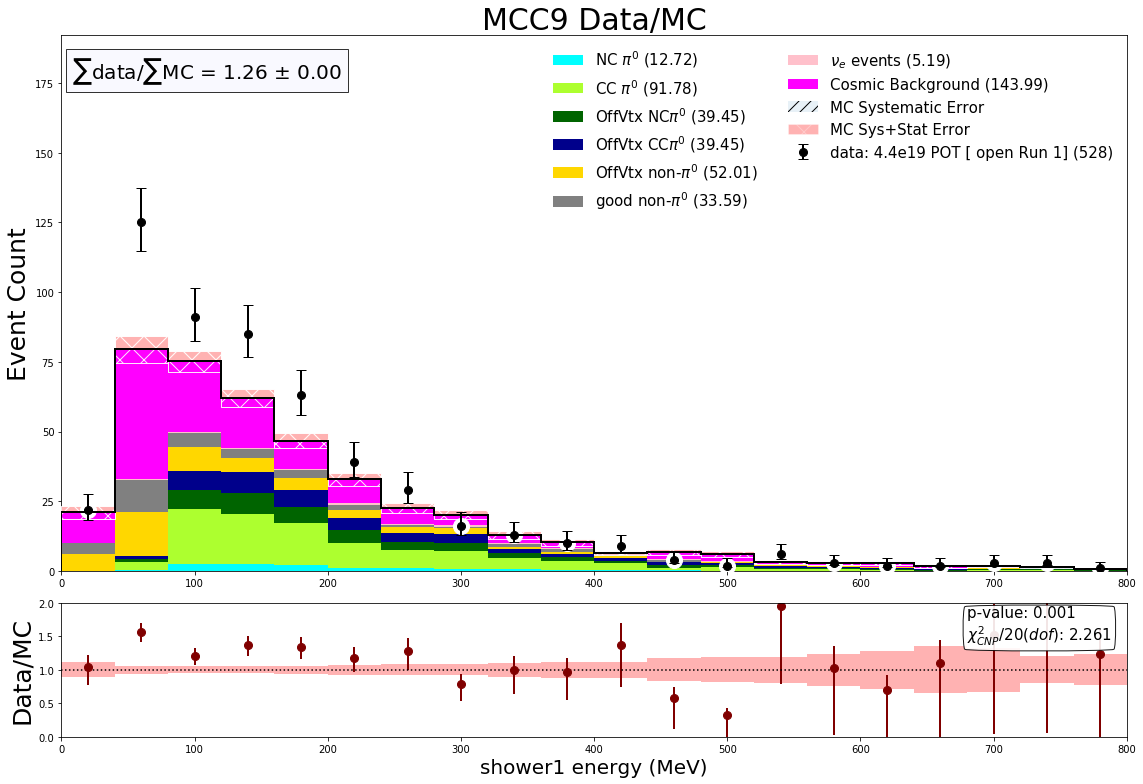

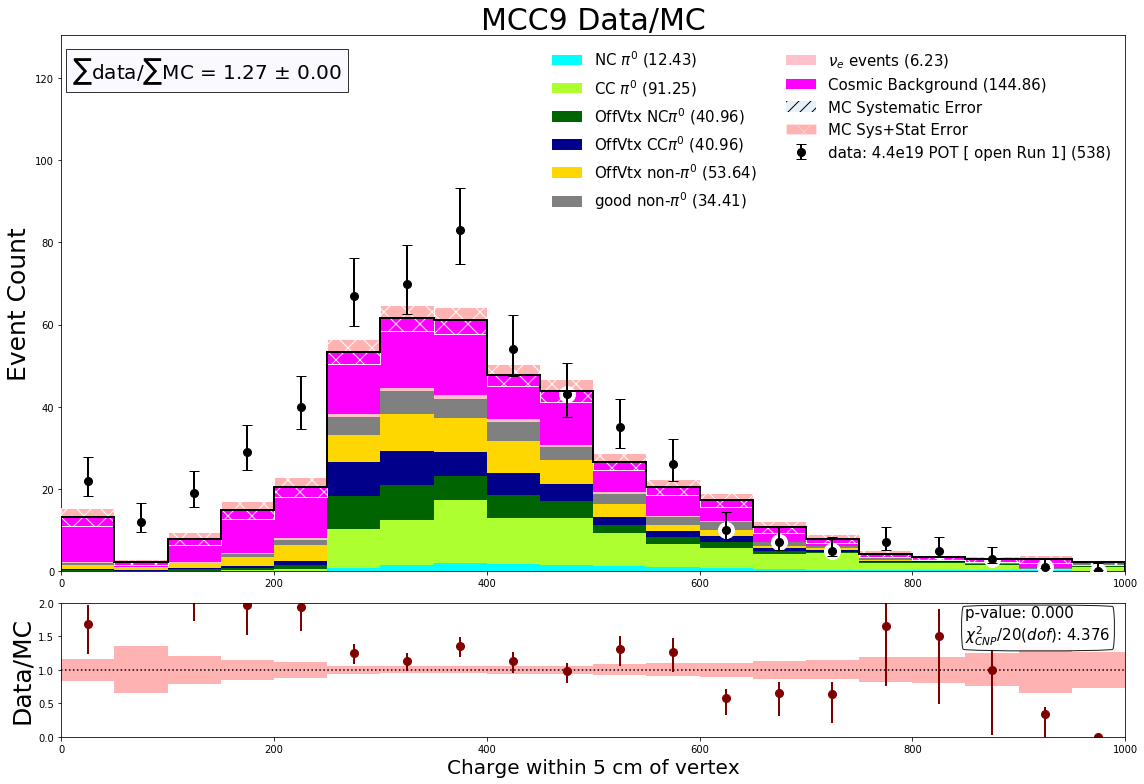

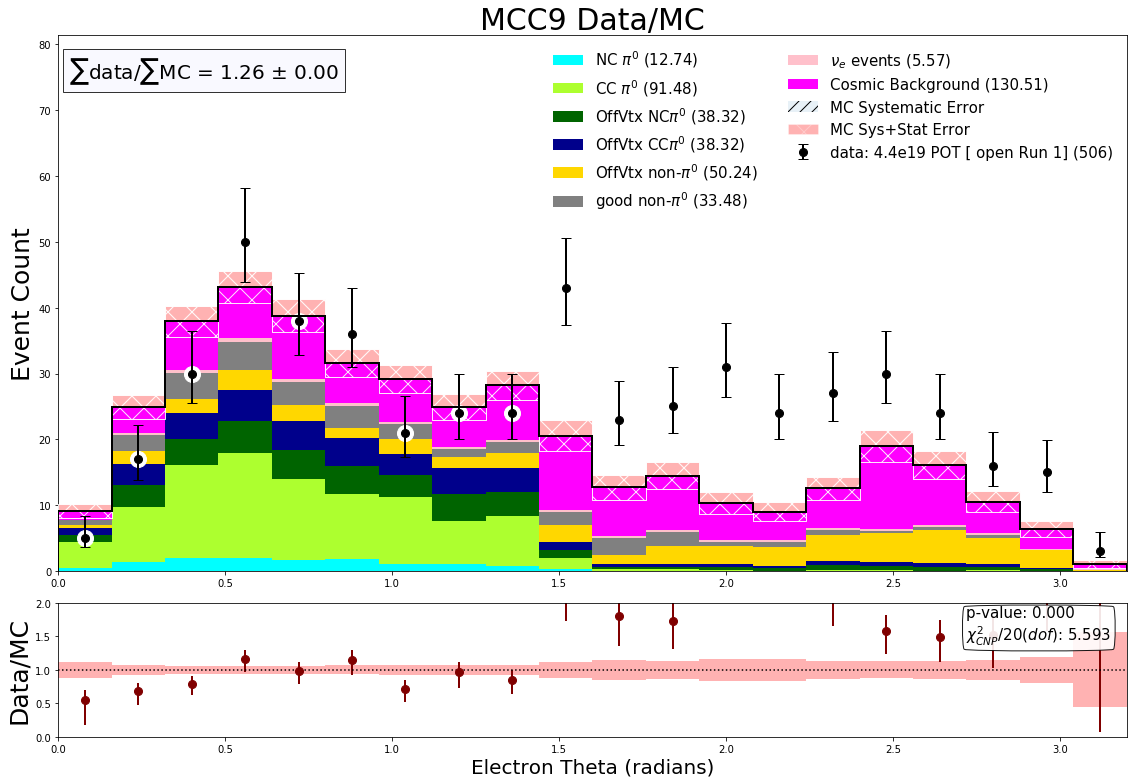

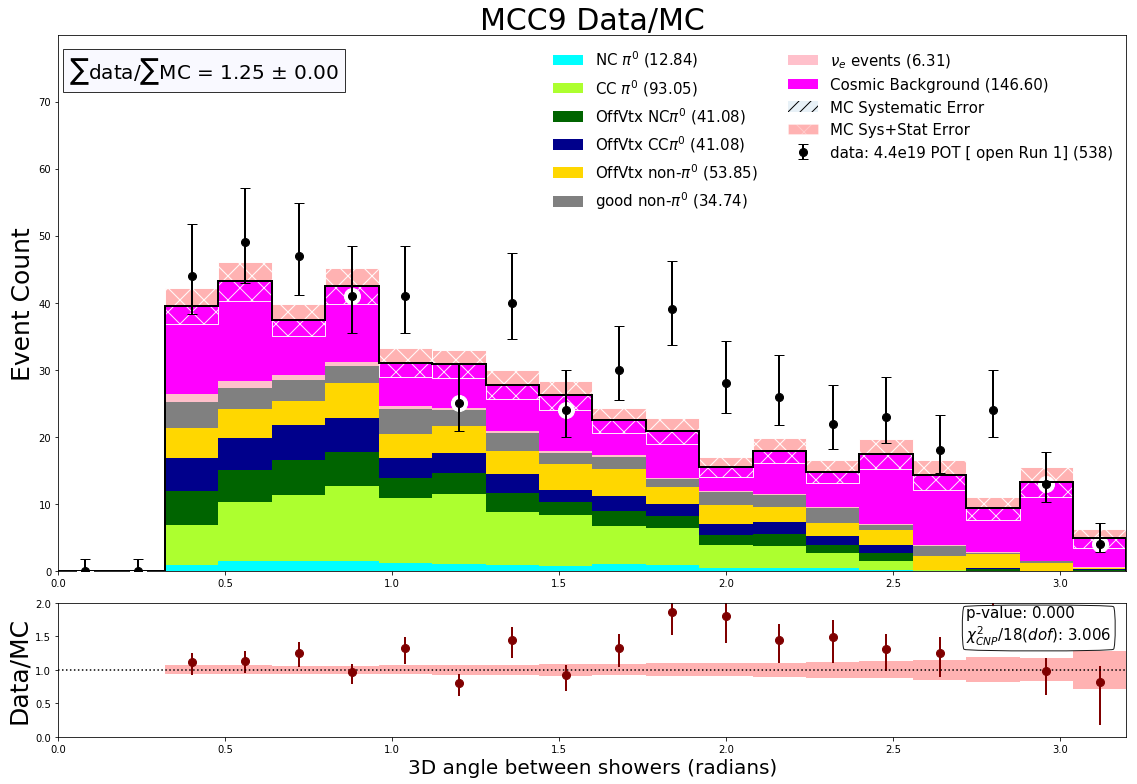

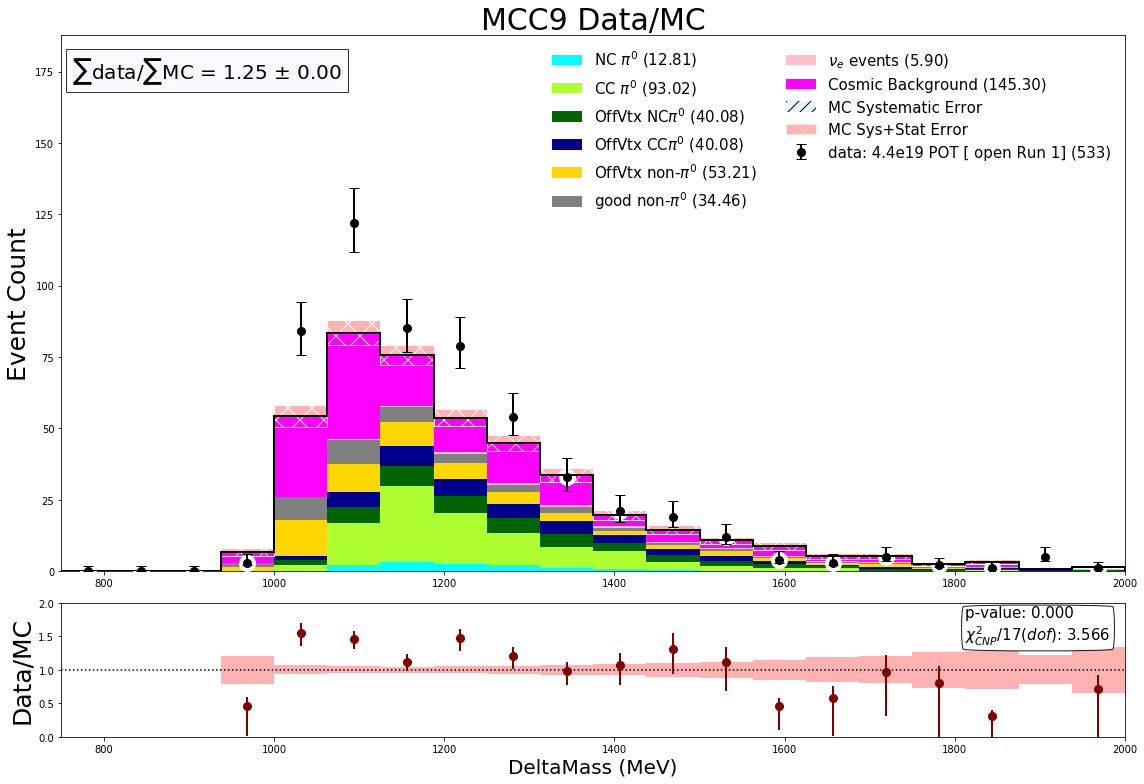

In [75]:
norm = 1.0
with PdfPages('output_preselection_201109.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        cov = np.zeros((nbins,nbins))
        
        run1_open_Hists = StackedHisto((df_bnb_ncpi0_pre,df_bnb_ccpi0_pre,df_bnb_ncpi0_offvtx_pre,df_bnb_ccpi0_offvtx_pre,df_bnb_other_offvtx_pre,df_bnb_other_good_pre,df_nue_pre),(NCPI0_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NCPI0_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,NUE_R1_OPEN_SCALE*norm))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx NC$\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx CC$\pi^0$",'darkblue')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_open_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_open_Hists.AddLayer(df_ext_pre,EXT_R1_OPEN_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_r1_open_pre,1.0,0,'','data: 4.4e19 POT [ open Run 1]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)

In [76]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((0.0,400.0))
# detvar_list.append('../systematics/detvar_pi0mass_cov.txt')
sys_list.append('none')
detvar_list.append('none')
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('Delta mass (MeV)')
myrange_list.append((1000.0,1400.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(10)

vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,800.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,800.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,350.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.01516179 0.01516179 0.01516179 ... 0.43501672 0.43501672 0.43501672]
Normalization Uncertainty: 0.0
0.8147660230102428 0.6916045232603933


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in true_divide


hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.06012376 0.06012376 0.06012376 ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.8695452015398846 0.012077769666920313


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:424: RuntimeWarning: invalid value encountered in true_divide
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.50126665 0.50126665 0.50126665 ... 1.24909725 1.24909725 1.24909725]
Normalization Uncertainty: 0.0
1.8281271345557364 0.015031238780817358
hstack gh_weights [1. 1. 1. ... 1. 1. 1.]
hstack gh_scale [0.15910937 0.15910937 0.15910937 ... 0.50331439 0.50331439 0.50331439]
Normalization Uncertainty: 0.0
1.6598324144971273 0.035218125043505966


NameError: name 'df_bnb_pi0_offvtx_r3' is not defined

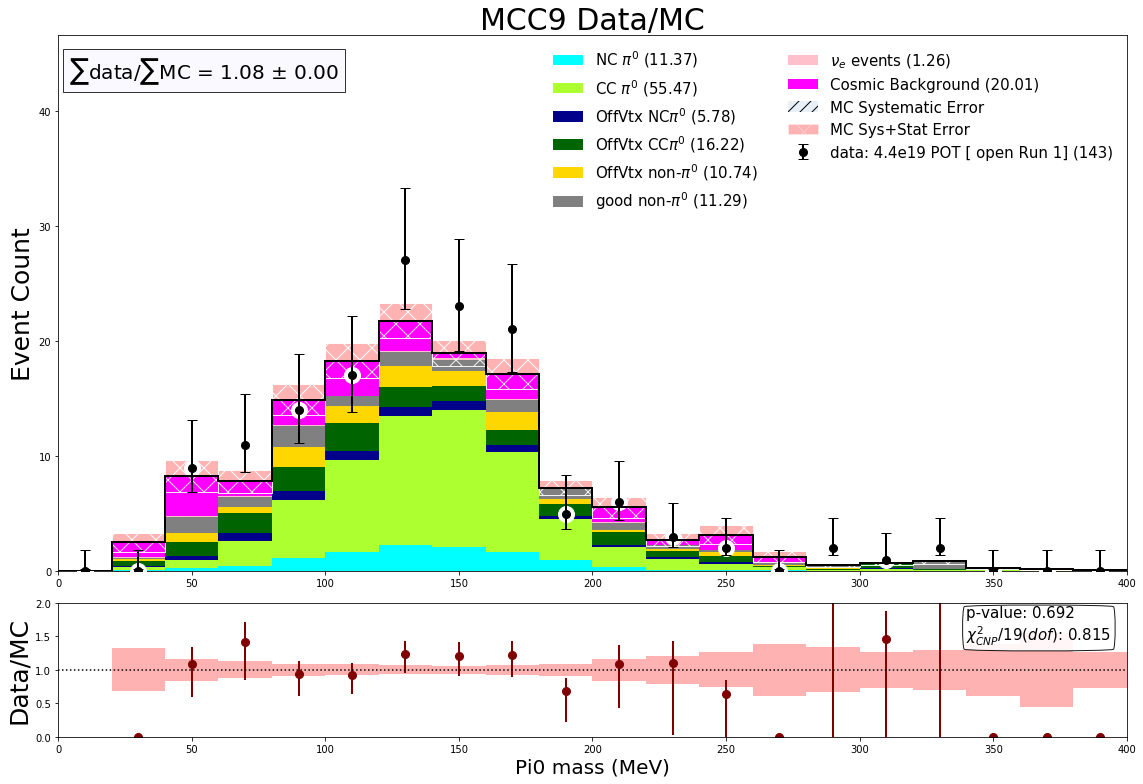

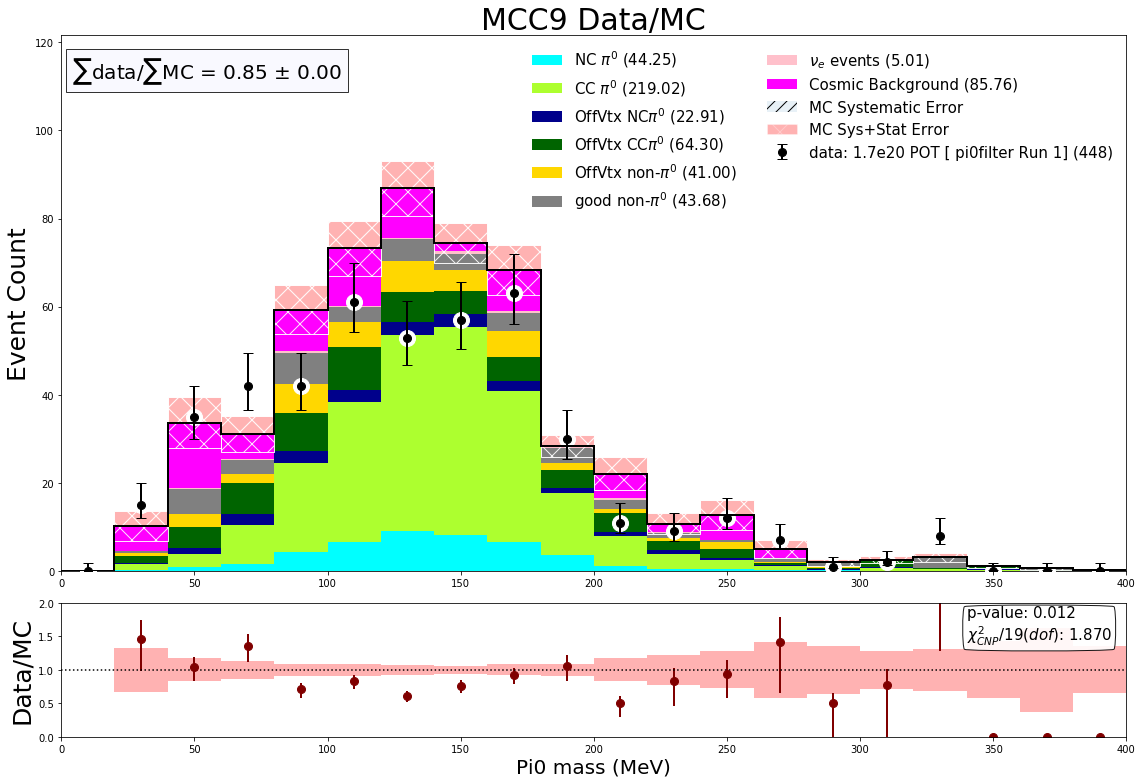

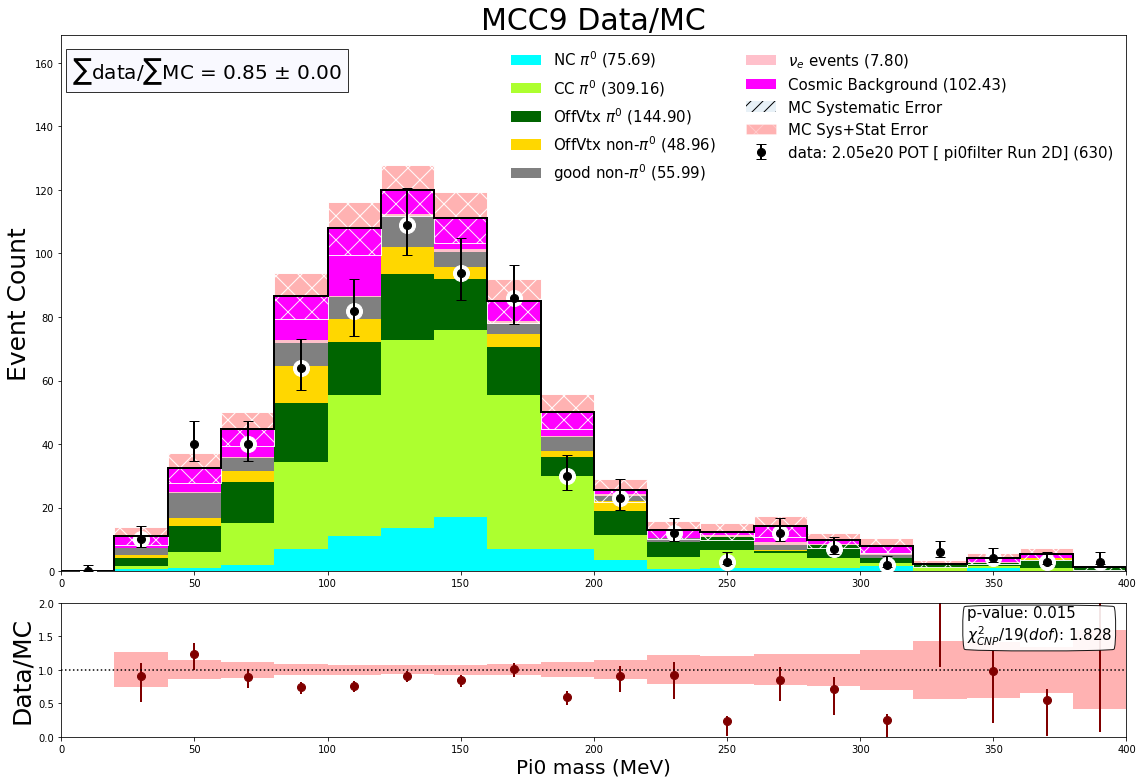

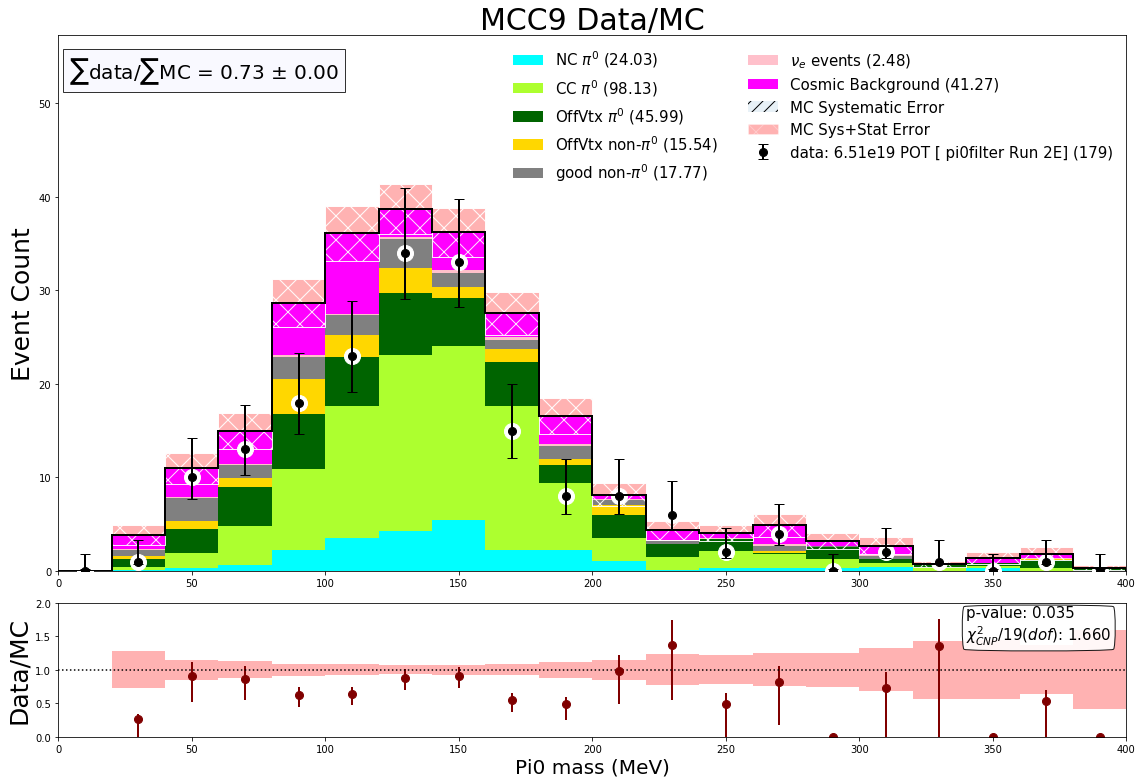

In [77]:
norm = 1.0
with PdfPages('output_201109.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        s_cov = np.zeros((nbins,nbins))
        if detvar_list[i] == 'none':
            d_cov = np.zeros((nbins,nbins))
        else:
            d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
        
        cov = s_cov +d_cov
        run1_open_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_ncpi0_offvtx,df_bnb_ccpi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NCPI0_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NCPI0_R1_OPEN_SCALE*norm,CCPI0_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,NUMU_R1_OPEN_SCALE*norm,NUE_R1_OPEN_SCALE*norm))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr>=5 ',r"OffVtx NC$\pi^0$",'darkblue')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==0 and MC_scedr>=5',r"OffVtx CC$\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_open_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_open_Hists.AddLayer(df_ext_pi0,EXT_R1_OPEN_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_r1_open_pi0,1.0,0,'','data: 4.4e19 POT [ open Run 1]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        run1_pi0filter_Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_ncpi0_offvtx,df_bnb_ccpi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NCPI0_R1_PI0FILTER_SCALE*norm,CCPI0_R1_PI0FILTER_SCALE*norm,NCPI0_R1_PI0FILTER_SCALE*norm,CCPI0_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUE_R1_PI0FILTER_SCALE*norm))
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr>=5 ',r"OffVtx NC$\pi^0$",'darkblue')
        run1_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==0 and MC_scedr>=5 ',r"OffVtx CC$\pi^0$",'darkgreen')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_pi0filter_Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_pi0filter_DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [ pi0filter Run 1]')
        fig3,ax3,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_pi0filter_Hists,run1_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        run2D_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r2,df_bnb_ccpi0_r2,df_bnb_pi0_offvtx_r2,df_bnb_other_offvtx_r2,df_bnb_other_good_r2,df_nue_r2_pi0),(NUMU_R2D_PI0FILTER_SCALE*norm,NUMU_R2D_PI0FILTER_SCALE*norm,NUMU_R2D_PI0FILTER_SCALE*norm,NUMU_R2D_PI0FILTER_SCALE*norm,NUMU_R2D_PI0FILTER_SCALE*norm,NUE_R2D_PI0FILTER_SCALE*norm))
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run2D_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run2D_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run2D_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2D_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run2D_pi0filter_DataHist = SimpleHisto(df_data_r2D_pi0filter_pi0,1.0,0,'','data: 2.05e20 POT [ pi0filter Run 2D]')
        fig4,ax4,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2D_pi0filter_Hists,run2D_pi0filter_DataHist,varname,m_cov=cov)
        
        cov = np.zeros((nbins,nbins))
        run2E_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r2,df_bnb_ccpi0_r2,df_bnb_pi0_offvtx_r2,df_bnb_other_offvtx_r2,df_bnb_other_good_r2,df_nue_r2_pi0),(NUMU_R2E_PI0FILTER_SCALE*norm,NUMU_R2E_PI0FILTER_SCALE*norm,NUMU_R2E_PI0FILTER_SCALE*norm,NUMU_R2E_PI0FILTER_SCALE*norm,NUMU_R2E_PI0FILTER_SCALE*norm,NUE_R2E_PI0FILTER_SCALE*norm))
        run2E_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run2E_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run2E_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run2E_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run2E_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run2E_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run2E_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2E_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run2E_pi0filter_DataHist = SimpleHisto(df_data_r2E_pi0filter_pi0,1.0,0,'','data: 6.51e19 POT [ pi0filter Run 2E]')
        fig5,ax5,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2E_pi0filter_Hists,run2E_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        run3F_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUMU_R3F_PI0FILTER_SCALE*norm,NUE_R3F_PI0FILTER_SCALE*norm))
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run3F_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run3F_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3F_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run3F_pi0filter_DataHist = SimpleHisto(df_data_r3F_pi0filter_pi0,1.0,0,'','data: 4.3e19 POT [ pi0filter Run 3F]')
        fig6,ax6,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3F_pi0filter_Hists,run3F_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        run3G_pi0filter_Hists = StackedHisto((df_bnb_ncpi0_r3,df_bnb_ccpi0_r3,df_bnb_pi0_offvtx_r3,df_bnb_other_offvtx_r3,df_bnb_other_good_r3,df_nue_r3_pi0),(NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUMU_R3G_PI0FILTER_SCALE*norm,NUE_R3G_PI0FILTER_SCALE*norm))
        run3G_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run3G_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run3G_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run3G_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run3G_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run3G_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run3G_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3G_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run3G_pi0filter_DataHist = SimpleHisto(df_data_r3G_pi0filter_pi0,1.0,0,'','data: 2e20 [ pi0filter Run 3G]')
        fig7,ax7,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3G_pi0filter_Hists,run3G_pi0filter_DataHist,varname,m_cov=cov)
        
        #save to pdf file of plots
        pdf.savefig(fig1)
        pdf.savefig(fig3)
        pdf.savefig(fig4)
        pdf.savefig(fig5)
        pdf.savefig(fig6)
        pdf.savefig(fig7)

In [ ]:
# Make data plots, normalized
# checking to see if any bins look realyl off
var_r1 = df_data_r1_pi0filter_pi0["_pi0mass_new"].values
var_r2D = df_data_r2D_pi0filter_pi0["_pi0mass_new"].values
var_r2E = df_data_r2E_pi0filter_pi0["_pi0mass_new"].values
var_r3F = df_data_r3F_pi0filter_pi0["_pi0mass_new"].values
var_r3G = df_data_r3G_pi0filter_pi0["_pi0mass_new"].values

# turn into histograms
r1_Hist,binedges = np.histogram( var_r1, bins = 20, range = [0,400],density = True)
bincenters = np.ones(len(binedges)-1)
for i in range(len(binedges)-1):
    bincenters[i] = binedges[i]+(400.0/15.0)
    
r2D_Hist,_ = np.histogram( var_r2D, bins = 20, range = [0,400],density = True)
r2E_Hist,_ = np.histogram( var_r2E, bins = 20, range = [0,400],density = True)
r3F_Hist,_ = np.histogram( var_r3F, bins = 20, range = [0,400],density = True)
r3G_Hist,_ = np.histogram( var_r3G, bins = 20, range = [0,400],density = True)

err_1 = [sqrt(float(i))/float(len(var_r1)) for i in r1_Hist]
err_2d = [sqrt(float(i))/float(len(var_r2D)) for i in r2D_Hist]
err_2e = [sqrt(float(i))/float(len(var_r2E)) for i in r2E_Hist]
err_3f = [sqrt(float(i))/float(len(var_r3F)) for i in r3F_Hist]
err_3g = [sqrt(float(i))/float(len(var_r3G)) for i in r3G_Hist]


plt.errorbar(bincenters,r1_Hist, yerr=err_1,  fmt='o', color = 'red', ecolor='red', capsize=5,label = 'run1')
plt.errorbar(bincenters,r2D_Hist, yerr=err_2d,  fmt='o', color = 'black', ecolor='black', capsize=5,label = 'run2D')
plt.errorbar(bincenters,r2E_Hist, yerr=err_2e,  fmt='o', color = 'blue', ecolor='blue', capsize=5,label = 'run2E')
plt.errorbar(bincenters,r3F_Hist, yerr=err_3f,  fmt='o', color = 'green', ecolor='green', capsize=5,label = 'run3F')
plt.errorbar(bincenters,r3G_Hist, yerr=err_3g,  fmt='o', color = 'orange', ecolor='orange', capsize=5,label = 'run3G')

plt.legend(loc='upper right',fontsize=15,frameon=False,ncol=1)
plt.show()
plt.close()

# Make "DPF plots"

In [ ]:
# # list of variables to plot:
# vars = ['Xreco','Yreco','Zreco','OpenAng','Thetas','Phis','ChargeNearTrunk','Enu_1e1p','PhiT_1e1p','AlphaT_1e1p','PT_1e1p','PTRat_1e1p','BjXB_1e1p','BjYB_1e1p','Q2_1e1p','SphB_1e1p','Q0_1e1p','Q3_1e1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','Proton_CosTheta','Lepton_CosTheta']
# # list of ranges
# ranges = [(15,241.25),(-101.5,101.),(15,1021.8),(.6,2.8),(0,6.3),(1.5,4),(0,600),(200,1200),(0,1),(0,np.pi),(0,320),(0,1),(0,1.8),(0.05,.75),(0,6e5),(0,1200),(70,600),(200,1000),(-np.pi,np.pi),(.2,2.8),(20,200),(50,600),(-np.pi,np.pi),(0,2),(5,100),(50,500),(-1,1),(-1,1),]
# print(vars)
# print(ranges)
# nbins =20

# for i in range(len(vars)):
#     vartest = vars[i]
#     varname = vars[i]
#     myrange = ranges[i]
#     norm = len(df_data_r1_pi0filter_pi0)/(len(df_numu_pi0)*NUMU_R1_PI0FILTER_SCALE+ len(df_nue_pi0)*NUE_R1_PI0FILTER_SCALE +len(df_ext_pi0)*EXT_R1_PI0FILTER_SCALE)
#     print("Norm", norm)
#     run1Hists = StackedHisto((df_bnb_ncpi0,df_bnb_ccpi0,df_bnb_pi0_offvtx,df_bnb_other_offvtx,df_bnb_other_good,df_nue_pi0),(NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUMU_R1_PI0FILTER_SCALE*norm,NUE_R1_PI0FILTER_SCALE*norm))
#     run1Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#     run1Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#     run1Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
#     run1Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#     run1Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#     run1Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
#     run1Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
#     run1DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [Run 1]')
#     cov = np.zeros((nbins,nbins))
#     fig,ax0,_ ,a= distplot_wratio_davio(vartest,nbins,myrange,run1Hists,run1DataHist,varname,m_cov=cov)

# Start of combined plots...

In [88]:
# add all of the data frames
# df_data_total = df_fakedata1_run1_pi0.append(df_fakedata1_run3_pi0)
df_data_total_1 = df_data_r1_pi0filter_pi0.append(df_data_r2D_pi0filter_pi0)
df_data_total_2 = df_data_total_1.append(df_data_r2E_pi0filter_pi0)
df_data_total_3 = df_data_total_2.append(df_data_r3F_pi0filter_pi0)
df_data_total = df_data_total_3.append(df_data_r3G_pi0filter_pi0)

print("total number of data pi0: ",len(df_data_total['_pi0mass'].values))
# scale CV weights:
def potscale(df,scalefactor=1.0,ext=False):
    pot_weight = []
    for i in range(len(df)):
        if ext==False:
            pot_weight.append(scalefactor)
        else:
            pot_weight.append(scalefactor)
    return pot_weight

# general mc
w_mu_1 =potscale(df_numu_pi0,DATA_R1_PI0FILTER_POT/NUMU_R1_POT)
w_mu_1_1mil =potscale(df_numu_1mil_pi0,DATA_R1_PI0FILTER_POT/NUMU_R1_1MIL_POT)
w_mu_2 =potscale(df_numu_r2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUMU_R2_POT)
w_mu_3 =potscale(df_numu_r3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/NUMU_R3_POT)
df_numu_pi0['pot_weight'] = w_mu_1
df_numu_1mil_pi0['pot_weight'] = w_mu_1_1mil
df_numu_r2_pi0['pot_weight'] = w_mu_2
df_numu_r3_pi0['pot_weight'] = w_mu_3

df_numu_total_1 = df_numu_pi0.append(df_numu_r2_pi0)
# df_numu_total_1 = df_numu_1mil_pi0.append(df_numu_r2_pi0)
df_numu_total = df_numu_total_1.append(df_numu_r3_pi0)

w_e_1 =potscale(df_nue_pi0,DATA_R1_PI0FILTER_POT/NUE_R1_POT)
w_e_2 =potscale(df_nue_r2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUE_R2_POT)
w_e_3 =potscale(df_nue_r3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/NUE_R3_POT)
df_nue_pi0['pot_weight'] = w_e_1
df_nue_r2_pi0['pot_weight'] = w_e_2
df_nue_r3_pi0['pot_weight'] = w_e_3
df_nue_total_1 = df_nue_pi0.append(df_nue_r2_pi0)
df_nue_total = df_nue_total_1.append(df_nue_r3_pi0)

df_ext_r3_2_pi0 = df_ext_r3_pi0
df_ext_r3_3_pi0 = df_ext_r3_pi0
w_ext_1 =potscale(df_ext_pi0,DATA_R1_PI0FILTER_POT/EXT_R1_PI0FILTER_POT,True)
w_ext_2 =potscale(df_ext_r3_2_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(EXT_R2D_PI0FILTER_POT+EXT_R2E_PI0FILTER_POT),True)
w_ext_3 =potscale(df_ext_r3_3_pi0,(DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/(EXT_R3F_PI0FILTER_POT+EXT_R3G_PI0FILTER_POT),True)
df_ext_pi0['pot_weight'] = w_ext_1
df_ext_r3_2_pi0['pot_weight'] = w_ext_2
df_ext_r3_2_pi0['pot_weight'] = w_ext_3
df_ext_total_1 = df_ext_pi0.append(df_ext_r3_2_pi0)
df_ext_total = df_ext_total_1.append(df_ext_r3_3_pi0)

# df_bnb_ncpi0_r2 = df_numu_r2_pi0.query('haspi0==1 and ccnc==1 and MC_scedr<5 and MC_parentPDG ==14')
# df_bnb_ccpi0_r2 = df_numu_r2_pi0.query("haspi0==1 and ccnc!=1 and MC_scedr<5 and MC_parentPDG ==14")

# df_bnb_offvtx_pi0_r2 = df_numu_r2_pi0.query("haspi0==1 and  MC_scedr>=5 and MC_parentPDG ==14")
# w_off_2 =potscale(df_bnb_offvtx_pi0_r2,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/NUMU_R2_POT)
# df_bnb_offvtx_pi0_r2['pot_weight'] = w_off_2

w_cc_1 =potscale(df_ccpi0_r1_pi0,DATA_R1_PI0FILTER_POT/CCPI0_R1_POT)
w_cc_3 =potscale(df_ccpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(CCPI0_R3_POT))
w_cc_2 =potscale(df_ccpi0_r3_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(CCPI0_R3_POT))
df_ccpi0_r1_pi0['pot_weight'] = w_cc_1
df_ccpi0_r3_pi0['pot_weight'] = w_cc_3
df_ccpi0_r2_pi0 = df_ccpi0_r3_pi0
df_ccpi0_r2_pi0['pot_weight'] = w_cc_2
df_ccpi0_total1 = df_ccpi0_r1_pi0.append(df_ccpi0_r2_pi0)
df_ccpi0_total = df_ccpi0_total1.append(df_ccpi0_r3_pi0)

w_nc_1 =potscale(df_ncpi0_r1_pi0,DATA_R1_PI0FILTER_POT/NCPI0_R1_POT)
w_nc_3 =potscale(df_ncpi0_r3_pi0,(DATA_R3G_PI0FILTER_POT+DATA_R3F_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT))
w_nc_2 =potscale(df_ncpi0_r3_pi0,(DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/(NCPI0_R3a_POT+NCPI0_R3b_POT))
df_ncpi0_r1_pi0['pot_weight'] = w_nc_1
df_ncpi0_r3_pi0['pot_weight'] = w_nc_3
df_ncpi0_r2_pi0 = df_ncpi0_r3_pi0
df_ncpi0_r2_pi0['pot_weight'] = w_nc_2
df_ncpi0_total1 = df_ncpi0_r1_pi0.append(df_ncpi0_r2_pi0)
df_ncpi0_total = df_ncpi0_total1.append(df_ncpi0_r3_pi0)

n=float(len(df_numu_total.query('newhaspi0==1') ))
print(sqrt(n)/n)
a = float(len(df_ncpi0_total)+len(df_ccpi0_total))
print(sqrt(a))
print(abs((234+1028+462)-(242+1039+472))/(234+1028+462))
                 
# tot1 = 0
# for i in range(len(df_numu_total)):
#     tot1+=df_numu_total['pot_weight'].values[i]*df_numu_total['xsec_corr_weight'].values[i]
# tot2 = 0
# for i in range(len(df_nue_total)):
#     tot2+=df_nue_total['pot_weight'].values[i]*df_nue_total['xsec_corr_weight'].values[i]
# print(tot1+tot2)
# tot3 = 0
# for i in range(len(df_ext_total)):
#     tot3+=df_ext_total['pot_weight'].values[i]
# print(tot3)


# # #specific categories
# df_bnb_ncpi0_total = df_numu_total.query('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ')
# tot4 = 0
# for i in range(len(df_bnb_ncpi0_total)):
#     tot4+=df_bnb_ncpi0_total['pot_weight'].values[i]*df_bnb_ncpi0_total['xsec_corr_weight'].values[i]
# print(tot4)
                 
# df_bnb_ccpi0_total = df_ccpi0_total.query(" MC_scedr<5 ") 
# df_bnb_ncpi0_total = df_ncpi0_total.query(" MC_scedr<5 ") 
# df_bnb_ccpi0_offvtx_total = df_ccpi0_total.query("MC_scedr>=5 ") 
# df_bnb_ncpi0_offvtx_total = df_ncpi0_total.query("MC_scedr>=5 ") 
# df_bnb_other_offvtx_total = df_numu_total.query("haspi0==0 and MC_scedr>=5 ")
# df_bnb_other_good_total = df_numu_total.query("haspi0==0 and MC_scedr<5")



# print(df_numu_pi0['xsec_corr_weight'].values)

total number of data pi0:  2016


/home/kmason/.local/lib/python3.5/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


0.015975990152658322
81.39410298049853
0.016821345707656612


In [89]:
NUMU_POT_TOTAL = NUMU_R1_1MIL_POT+NUMU_R2_POT+NUMU_R3_POT
NUE_POT_TOTAL = NUE_R1_POT+NUE_R2_POT+NUE_R3_POT
EXT_POT_TOTAL = EXT_R1_PI0FILTER_POT+EXT_R2D_PI0FILTER_POT+EXT_R2E_PI0FILTER_POT+EXT_R3F_PI0FILTER_POT+EXT_R3G_PI0FILTER_POT
CCPI0_POT_TOTAL = CCPI0_R1_POT+CCPI0_R3_POT
NCPI0_POT_TOTAL = NCPI0_R1_POT+NCPI0_R3a_POT+NCPI0_R3b_POT

# DATA_POT_TOTAL = FAKE_DATA_1_RUN1_POT + FAKE_DATA_1_RUN3_POT
DATA_POT_TOTAL = DATA_R1_PI0FILTER_POT+ DATA_R2D_PI0FILTER_POT+ DATA_R2E_PI0FILTER_POT+ DATA_R3F_PI0FILTER_POT+ DATA_R3G_PI0FILTER_POT
DATA_R2_POT_TOTAL = DATA_R2D_PI0FILTER_POT+ DATA_R2E_PI0FILTER_POT
print("pot total:",DATA_POT_TOTAL)
POT_SCALE_FACTOR = DATA_POT_TOTAL
NUMU_SCALE_TOTAL = POT_SCALE_FACTOR / float(NUMU_POT_TOTAL)
NUE_SCALE_TOTAL = POT_SCALE_FACTOR / float(NUE_POT_TOTAL)
CCPI0_SCALE_TOTAL =POT_SCALE_FACTOR / float(CCPI0_POT_TOTAL)
NCPI0_SCALE_TOTAL = POT_SCALE_FACTOR / float(NCPI0_POT_TOTAL)
EXT_SCALE_TOTAL = POT_SCALE_FACTOR / float(EXT_POT_TOTAL)
DATA_SCALE_TOTAL = POT_SCALE_FACTOR / float(DATA_POT_TOTAL)
print(CCPI0_SCALE_TOTAL)

pot total: 6.8767e+20
0.5340889762550319


In [90]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []

vartest_list.append('_pi0mass_new')
varname_list.append('Pi0 mass (MeV)')
myrange_list.append((30.0,375.0))
sys_list.append('none')
detvar_list.append('none')
bins_list.append(20)

vartest_list.append('DeltaMass_new')
varname_list.append('Delta mass (MeV)')
myrange_list.append((1000,1400))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('pi0_energy_reco_new')
varname_list.append('Pi0 Energy (MeV)')
myrange_list.append((100.0,750.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('pi0_momentum_reco_new')
varname_list.append('Pi0 Momentum (MeV)')
myrange_list.append((100.0,700.0))
detvar_list.append('none')
sys_list.append('none')
# sys_list.append('../systematics/covar_cv_weighted__pi0_momentum_reco.txt')
bins_list.append(20)

vartest_list.append('shower1_E_Y_new')
varname_list.append('shower1 energy (MeV)')
myrange_list.append((80.0,450.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

vartest_list.append('shower2_E_Y_new')
varname_list.append('shower2 energy (MeV)')
myrange_list.append((35.0,300.0))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)


vartest_list.append('MPID_muon')
varname_list.append('MPID muon score')
myrange_list.append((0,1))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)

/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.3589816102808885 0.13028540710868086


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
1.007988267235724 0.4479763493178788
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.3935570982889804 0.11248497484068931


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
0.7123671932809621 0.8177368016204585
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.820535125823214 0.013756674432230387


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
0.8481284353345536 0.6554028780091958
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.6370499308462587 0.03601484537662758


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
1.2531238497308697 0.19905133932707375
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.3127444399828185 0.15755775950397077


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
0.8843647071389341 0.6079992205599941
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.2738706364920858 0.18377292662967093


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
0.8720791059183929 0.6241417205228502
hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 1.         1.         1.        ]
hstack gh_scale [1.         1.         1.         ... 1.86424142 1.86424142 1.86424142]
Normalization Uncertainty: 0.0
1.544370022967466 0.05669461123792696


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.27036854 0.27036854 0.27036854 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
1.3330047185865548 0.14510066357506113


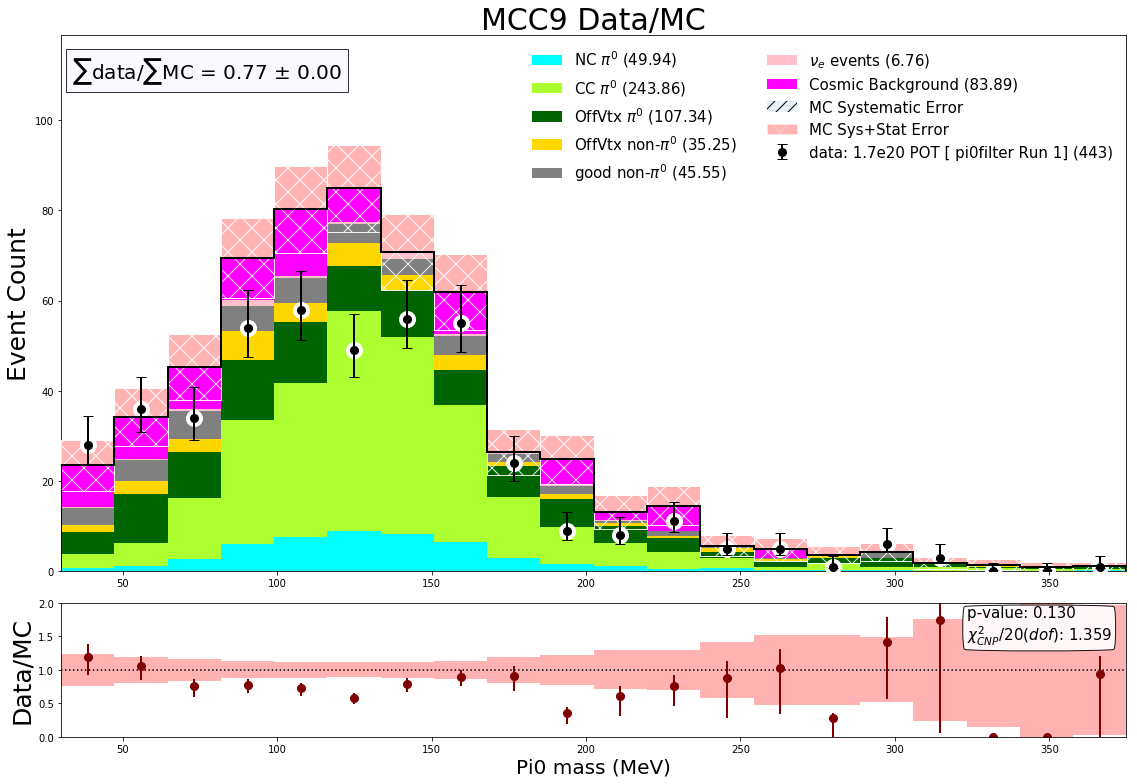

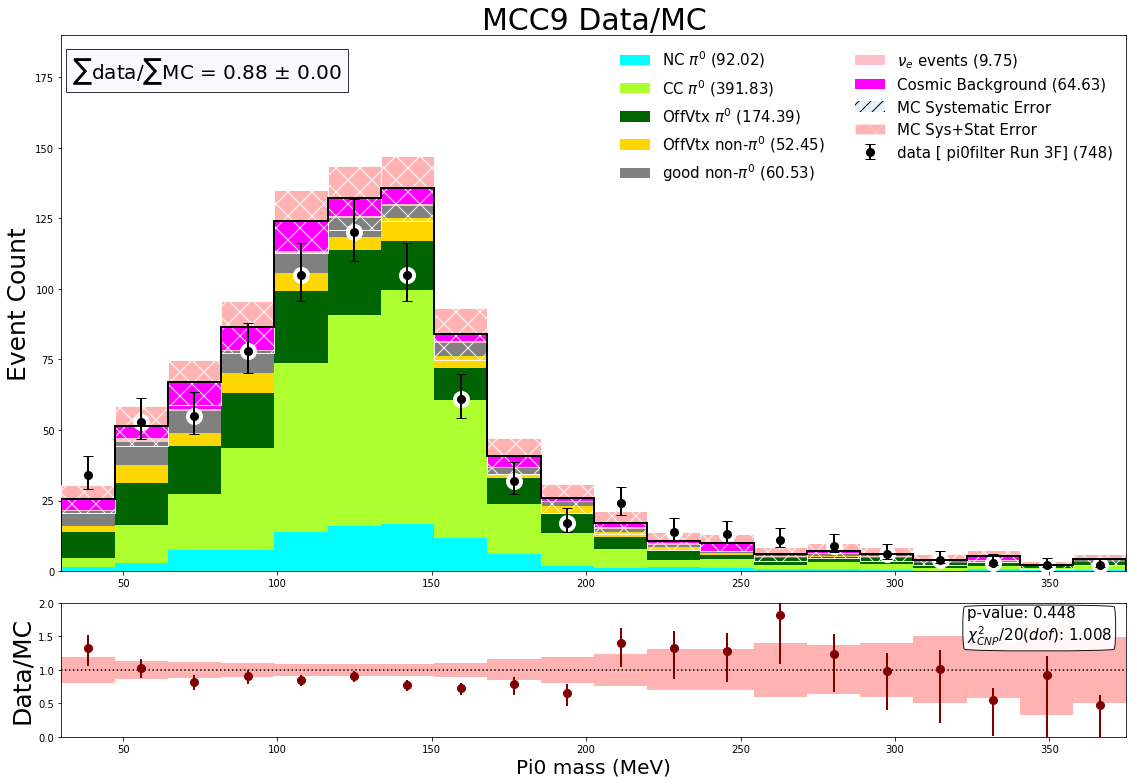

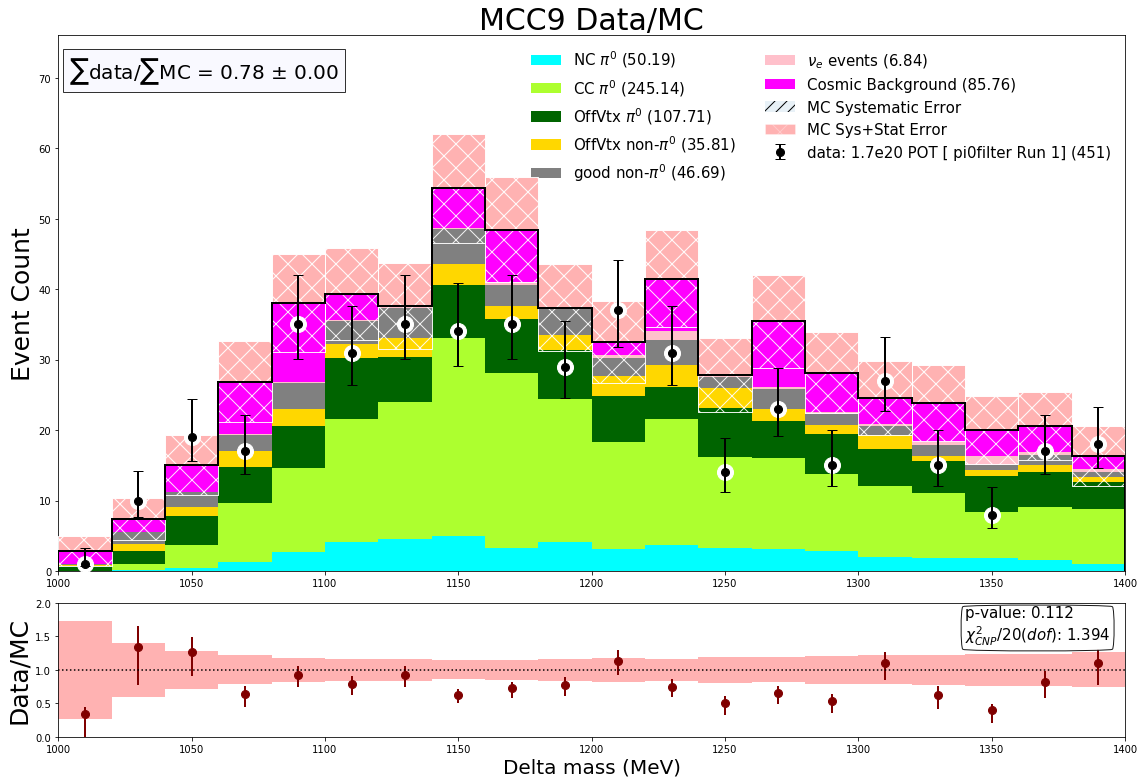

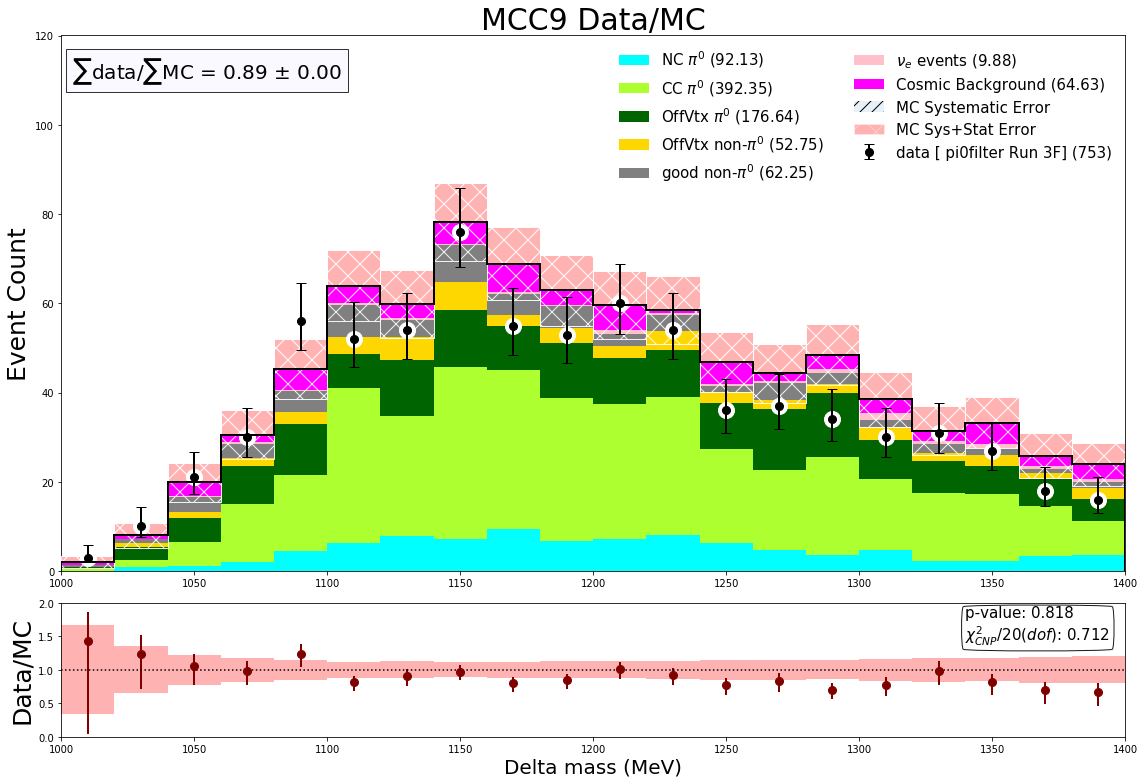

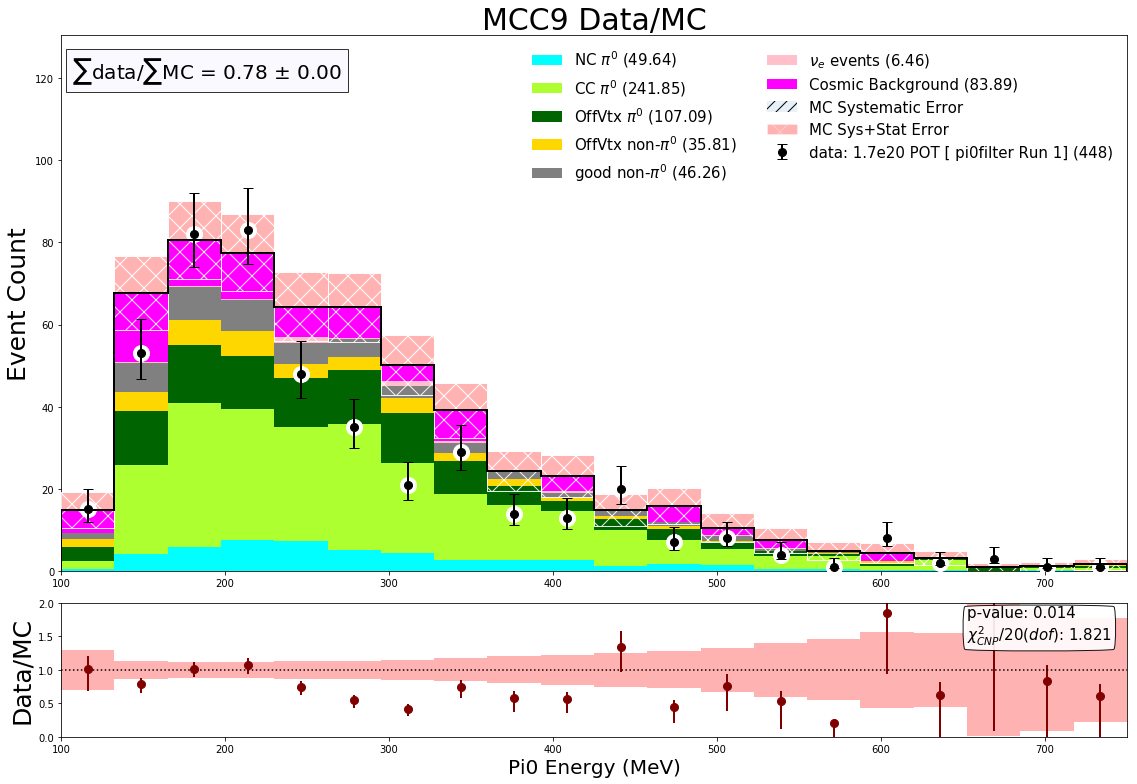

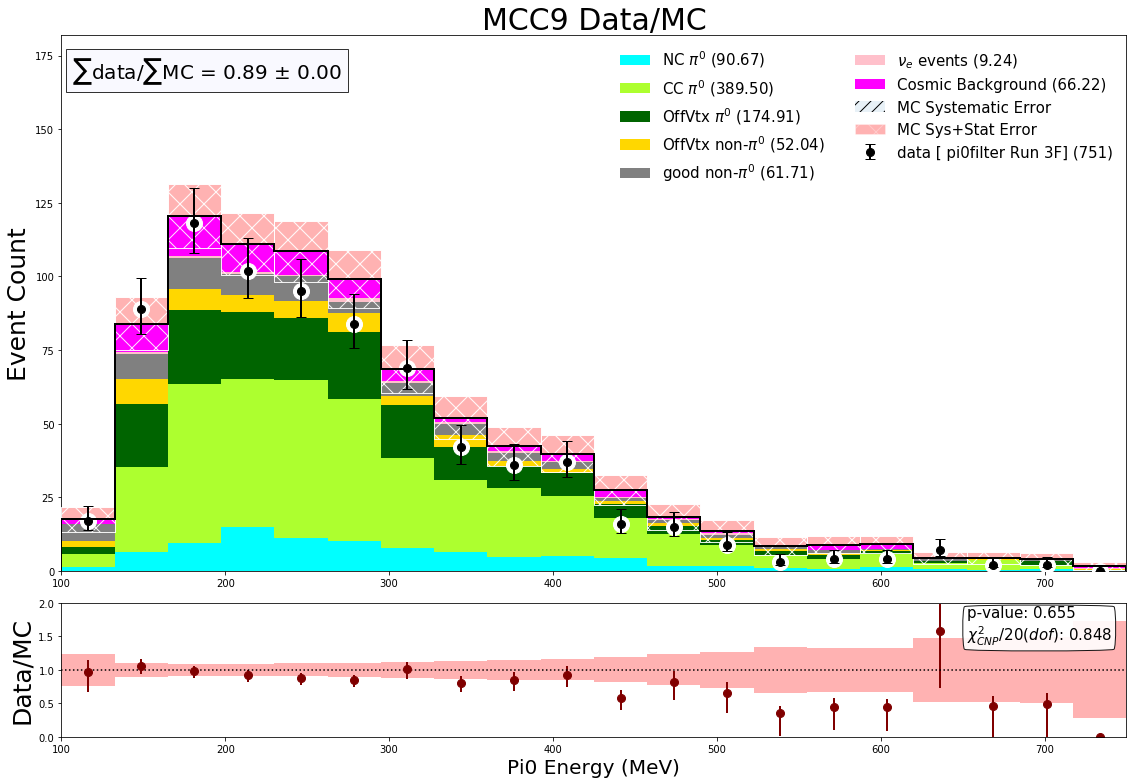

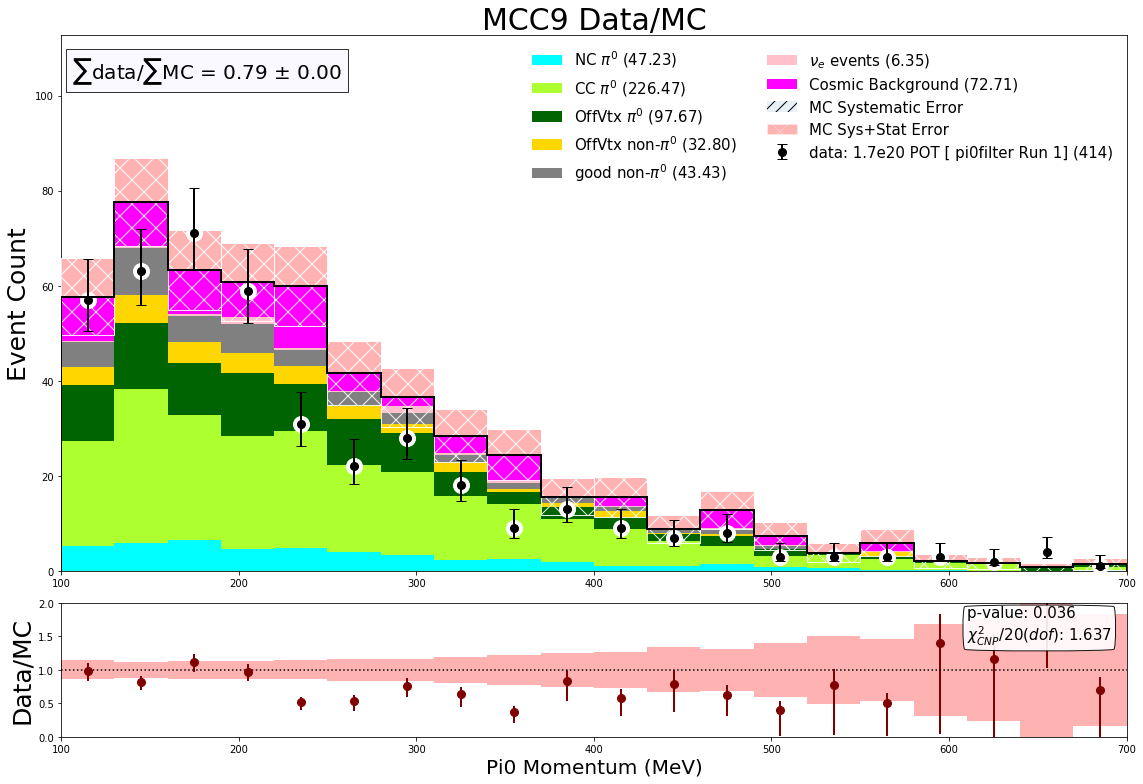

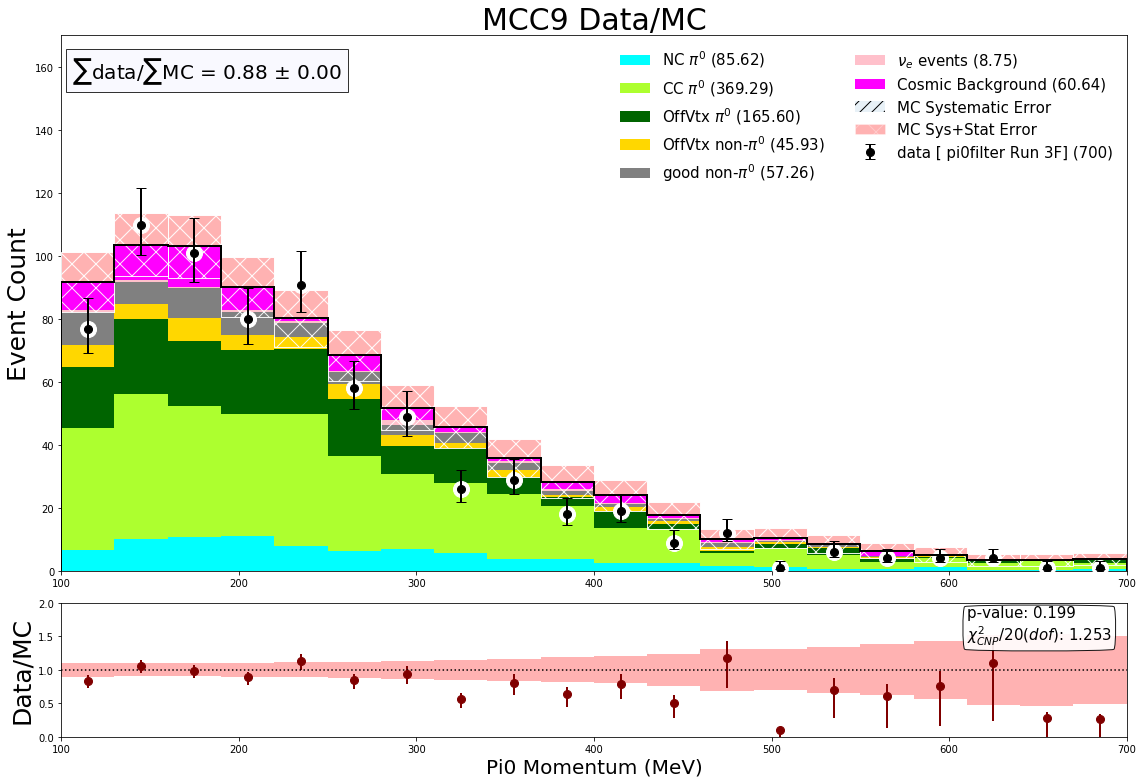

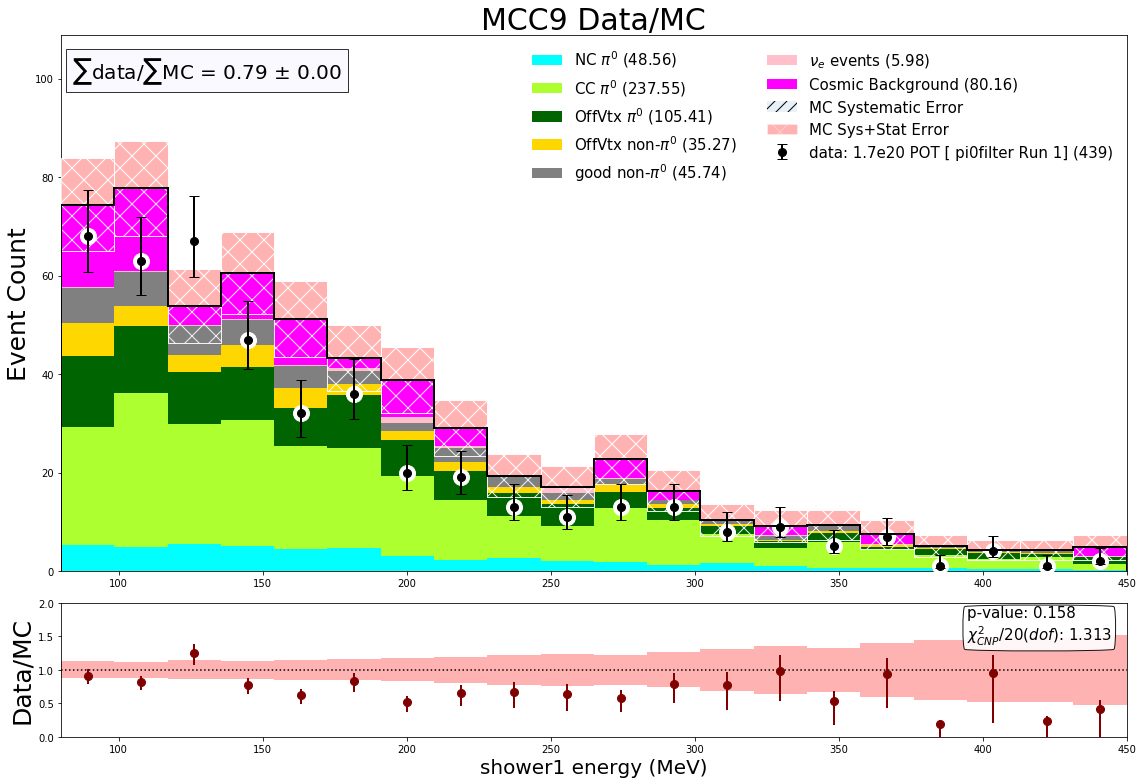

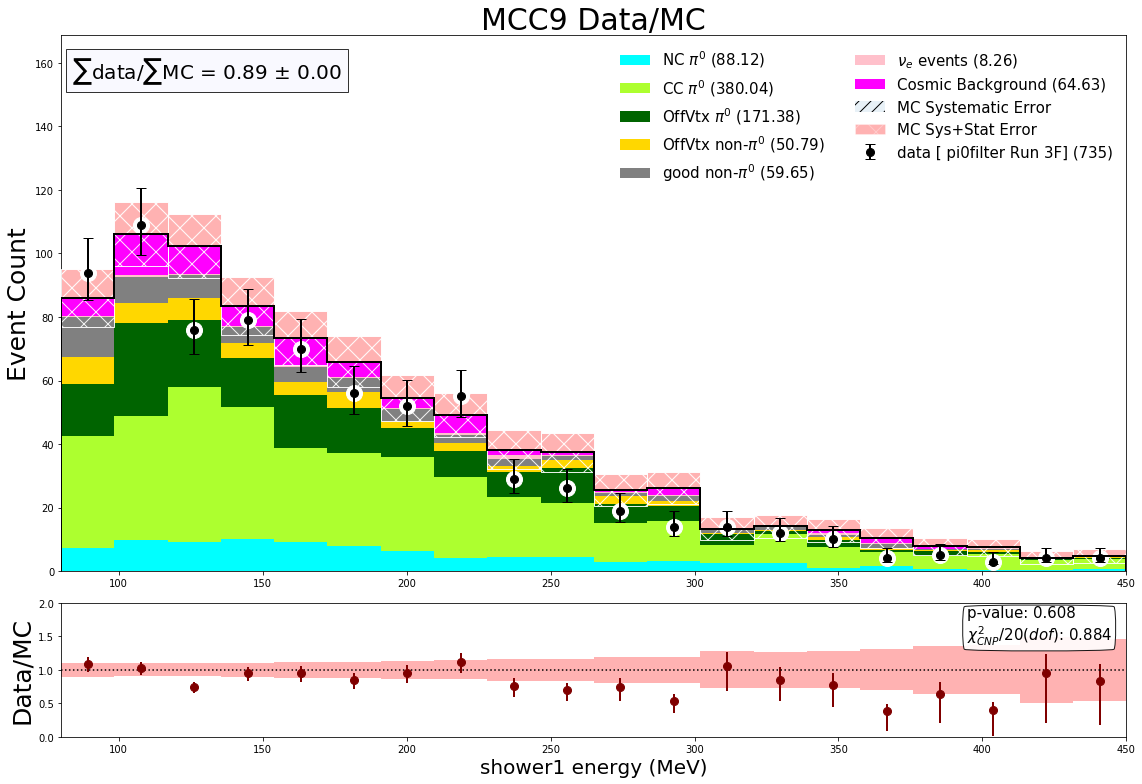

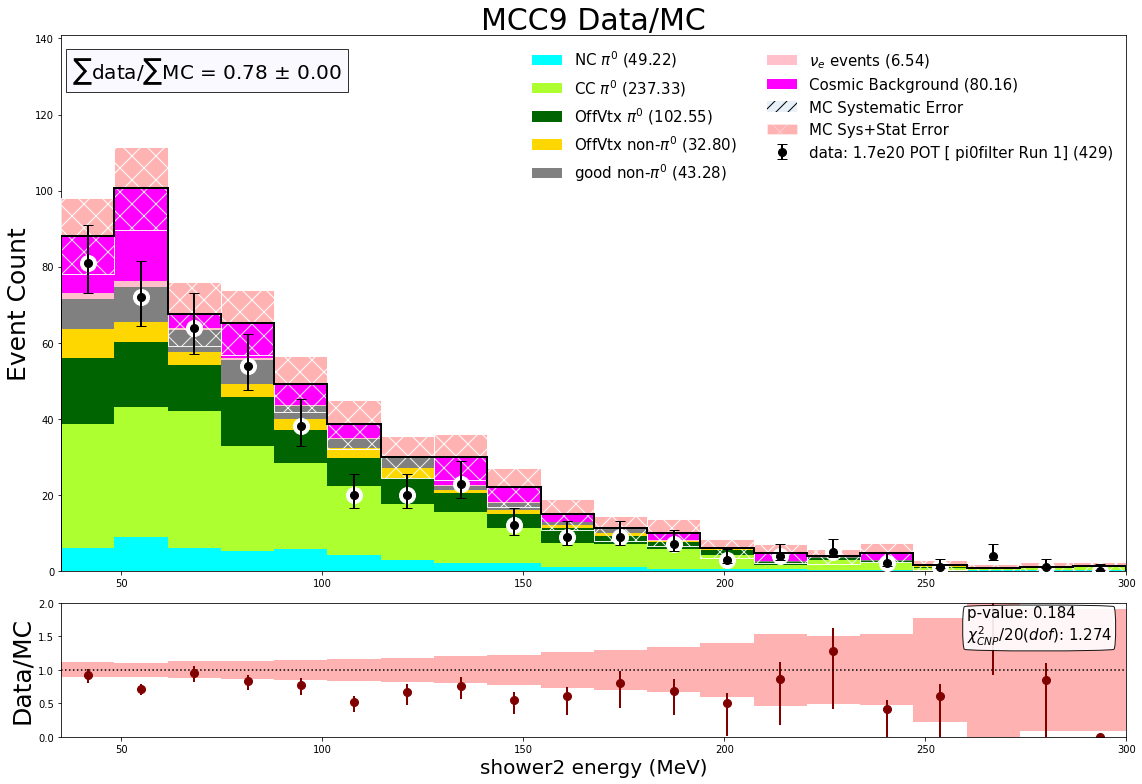

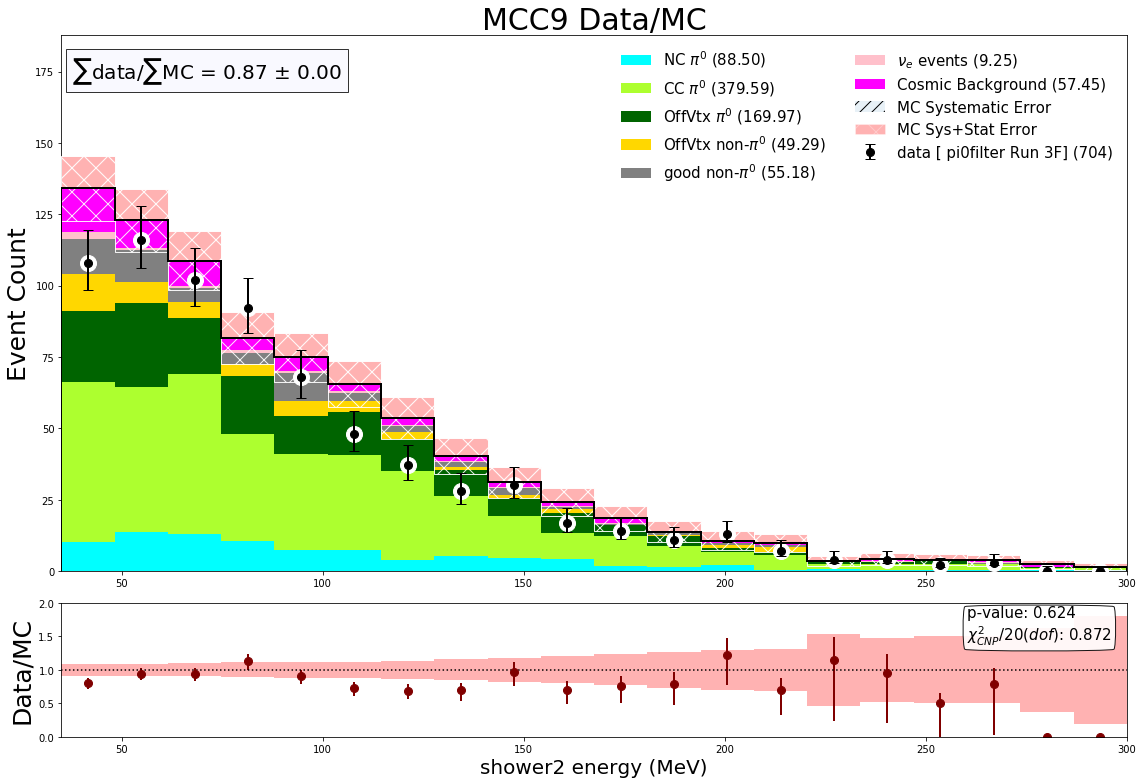

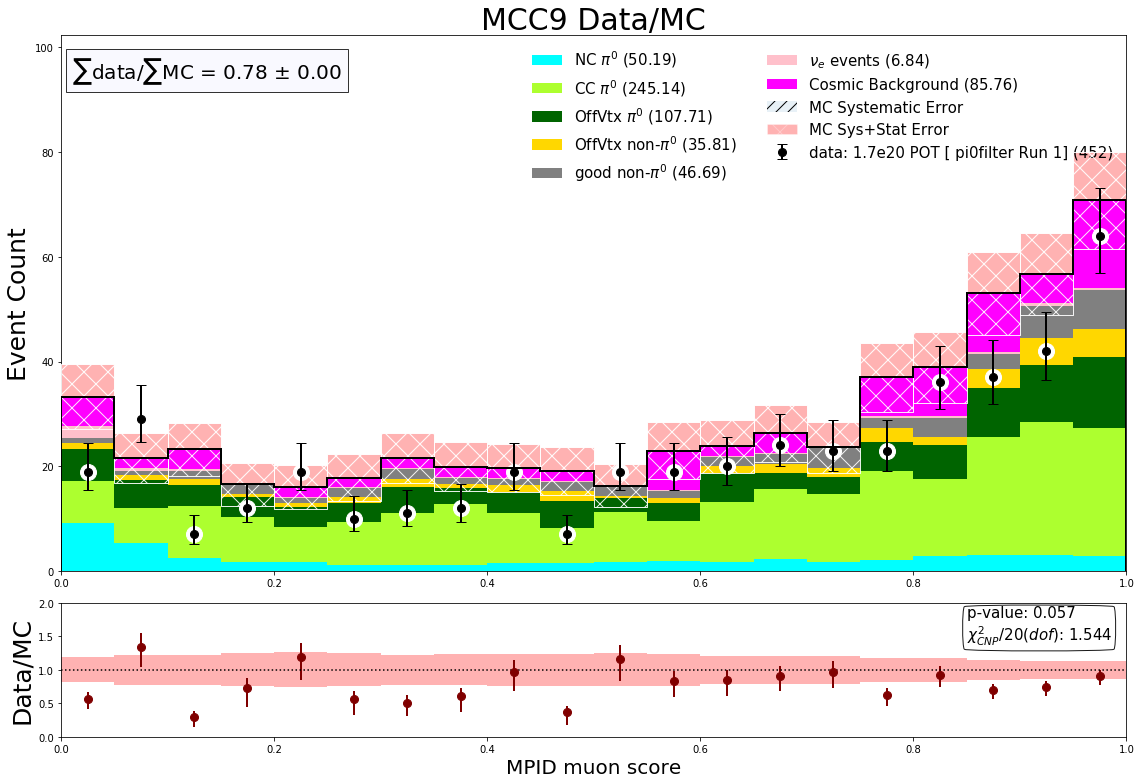

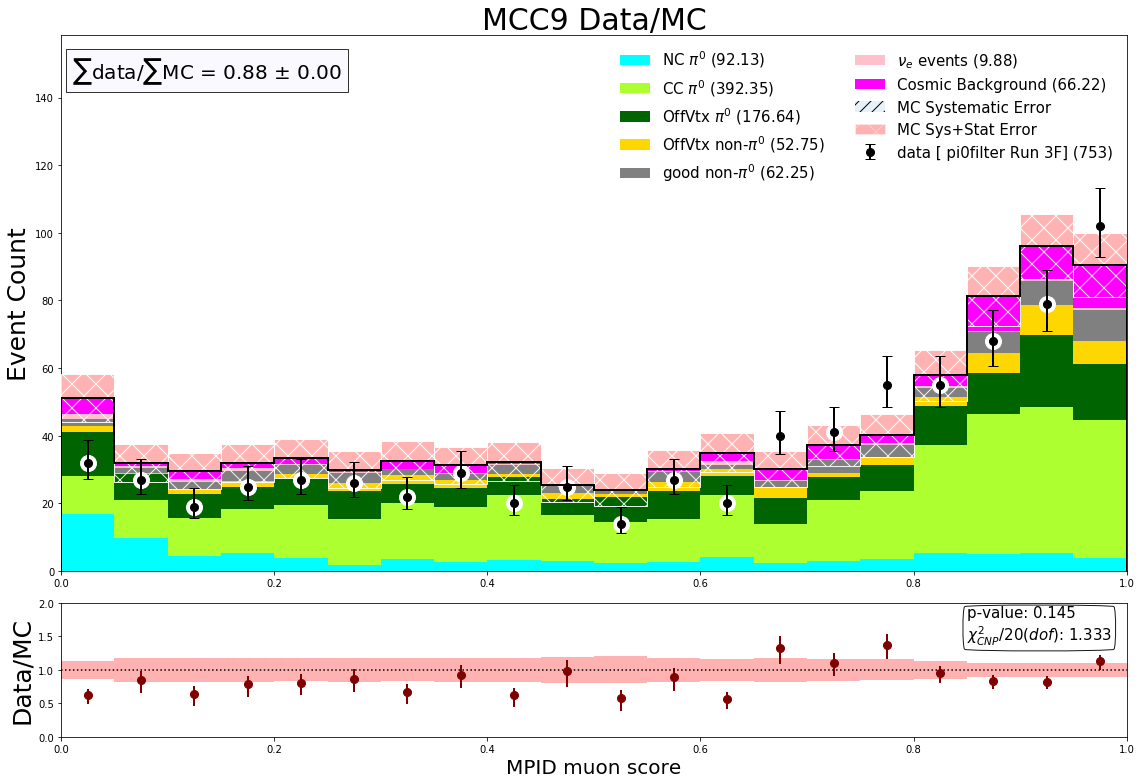

In [91]:
# individual runs again

EXT_R2_PI0FILTER_POT = EXT_R2D_PI0FILTER_POT +EXT_R2E_PI0FILTER_POT
EXT_R3_PI0FILTER_POT = EXT_R3F_PI0FILTER_POT +EXT_R3G_PI0FILTER_POT
EXT_R2_PI0FILTER_SCALE =  (DATA_R2D_PI0FILTER_POT+DATA_R2E_PI0FILTER_POT)/ float(EXT_R2_PI0FILTER_POT)
EXT_R3_PI0FILTER_SCALE =  (DATA_R3F_PI0FILTER_POT+DATA_R3G_PI0FILTER_POT)/ float(EXT_R3_PI0FILTER_POT)

norm = 1.0
with PdfPages('output_20210205_individualruns_original.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]

        cov = np.zeros((nbins,nbins))
        run1_pi0filter_Hists = StackedHisto((df_numu_1mil_pi0.query('newhaspi0==0'),df_nue_pi0,df_ccpi0_r1_pi0,df_ncpi0_r1_pi0),(1.0,1.0,1.0,1.0))
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_pi0filter_Hists.AddStrata('haspi0==1  and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_pi0filter_Hists.AddLayer(df_ext_pi0,EXT_R1_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run1_pi0filter_DataHist = SimpleHisto(df_data_r1_pi0filter_pi0,1.0,0,'','data: 1.7e20 POT [ pi0filter Run 1]')
        fig3,ax3,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_pi0filter_Hists,run1_pi0filter_DataHist,varname,m_cov=cov)

#         cov = np.zeros((nbins,nbins))
#         df_data_r2=df_data_r2D_pi0filter_pi0.append(df_data_r2E_pi0filter_pi0)
#         run2D_pi0filter_Hists = StackedHisto((df_numu_r2_pi0,df_nue_r2_pi0),(1.0,1.0))
#         run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
#         run2D_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
#         run2D_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
#         run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#         run2D_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#         run2D_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
#         run2D_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R2_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
#         run2D_pi0filter_DataHist = SimpleHisto(df_data_r2,1.0,0,'','data [ pi0filter Run 2]')
#         fig4,ax4,_,a = distplot_wratio_davio(vartest,nbins,myrange,run2D_pi0filter_Hists,run2D_pi0filter_DataHist,varname,m_cov=cov)

        cov = np.zeros((nbins,nbins))
        df_data_r3=df_data_r3F_pi0filter_pi0.append(df_data_r3G_pi0filter_pi0)
        run3F_pi0filter_Hists = StackedHisto((df_numu_r3_pi0.query('newhaspi0==0'),df_nue_r3_pi0,df_ccpi0_r3_pi0,df_ncpi0_r3_pi0),(1.0,1.0,1.0,1.0))
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run3F_pi0filter_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run3F_pi0filter_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run3F_pi0filter_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run3F_pi0filter_Hists.AddLayer(df_ext_r3_pi0,EXT_R3_PI0FILTER_SCALE*norm,0,'Cosmic Background','fuchsia')
        run3F_pi0filter_DataHist = SimpleHisto(df_data_r3,1.0,0,'','data [ pi0filter Run 3F]')
        fig6,ax6,_,a = distplot_wratio_davio(vartest,nbins,myrange,run3F_pi0filter_Hists,run3F_pi0filter_DataHist,varname,m_cov=cov)

        #save to pdf file of plots
#         pdf.savefig(fig1)
#         pdf.savefig(fig3)
#         pdf.savefig(fig4)
#         pdf.savefig(fig5)
#         pdf.savefig(fig6)
#         pdf.savefig(fig7)

In [92]:
print(len(df_numu_pi0.query('newhaspi0==1 and MC_scedr<5 and ccnc==0'))*(DATA_R1_PI0FILTER_POT)/NUMU_R1_POT)
print(len(df_ccpi0_r1_pi0.query('MC_scedr<5'))*(DATA_R1_PI0FILTER_POT)/CCPI0_R1_POT)

244.7322717932732
218.4559009641271


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



hstack gh_weights [0.37024549 0.37024549 0.37024549 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
1.9156340077740004 0.00810792026328877
hstack gh_weights [0.37024549 0.37024549 0.37024549 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
2.137840456952789 0.002201065085832399
hstack gh_weights [0.37024549 0.37024549 0.37024549 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
2.214552016716639 0.0013755366311867245
hstack gh_weights [0.37024549 0.37024549 0.37024549 ... 1.         1.         1.        ]
hstack gh_scale [1.        1.        1.        ... 0.7978831 0.7978831 0.7978831]
Normalization Uncertainty: 0.0
2.188762213782151 0.001612758661508451
hstack gh_weights [0.37024549 0

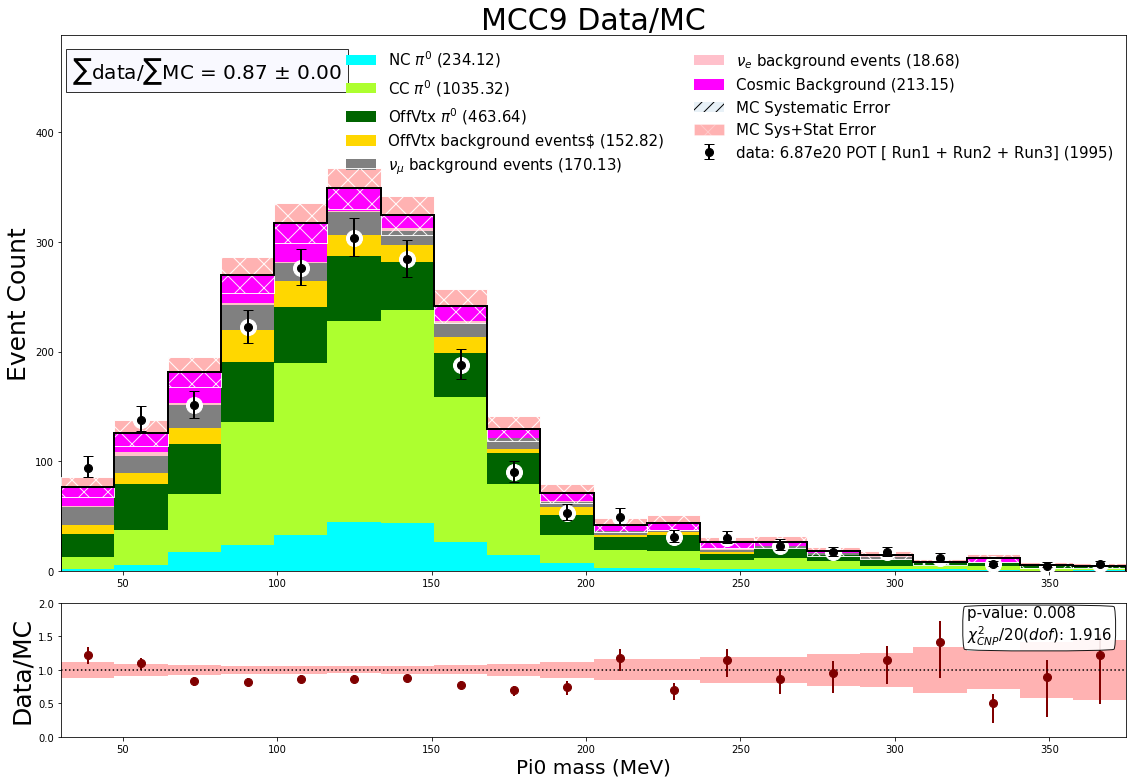

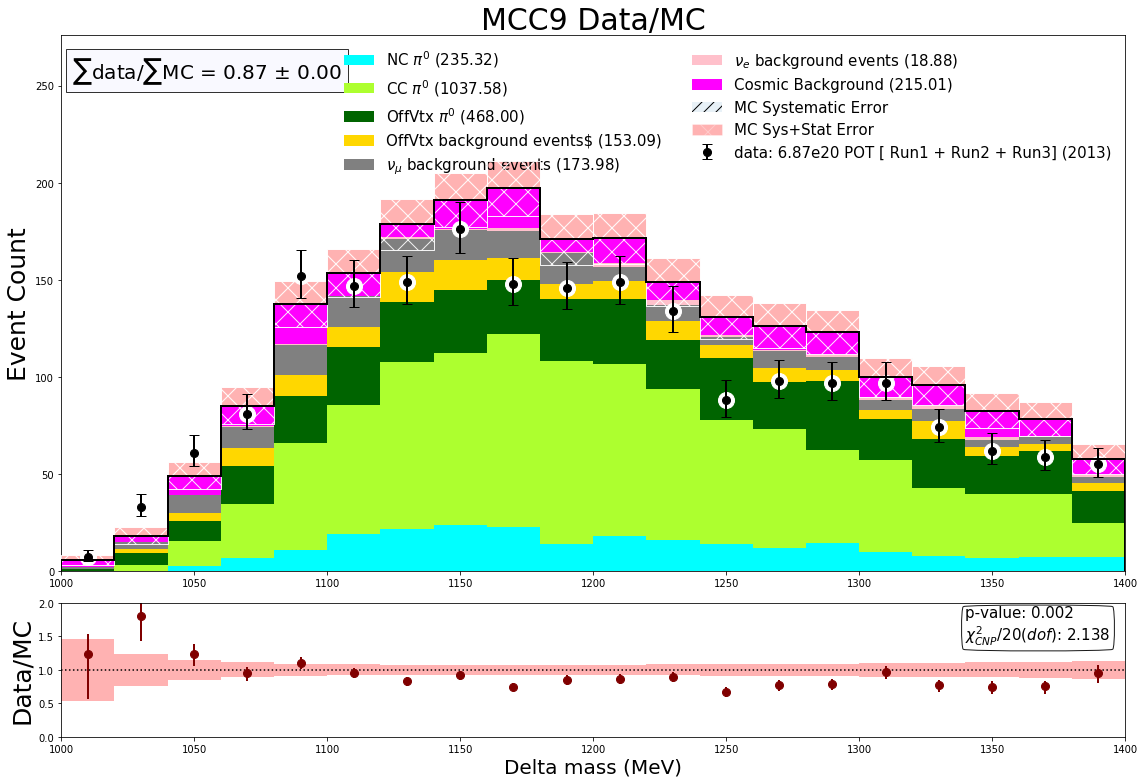

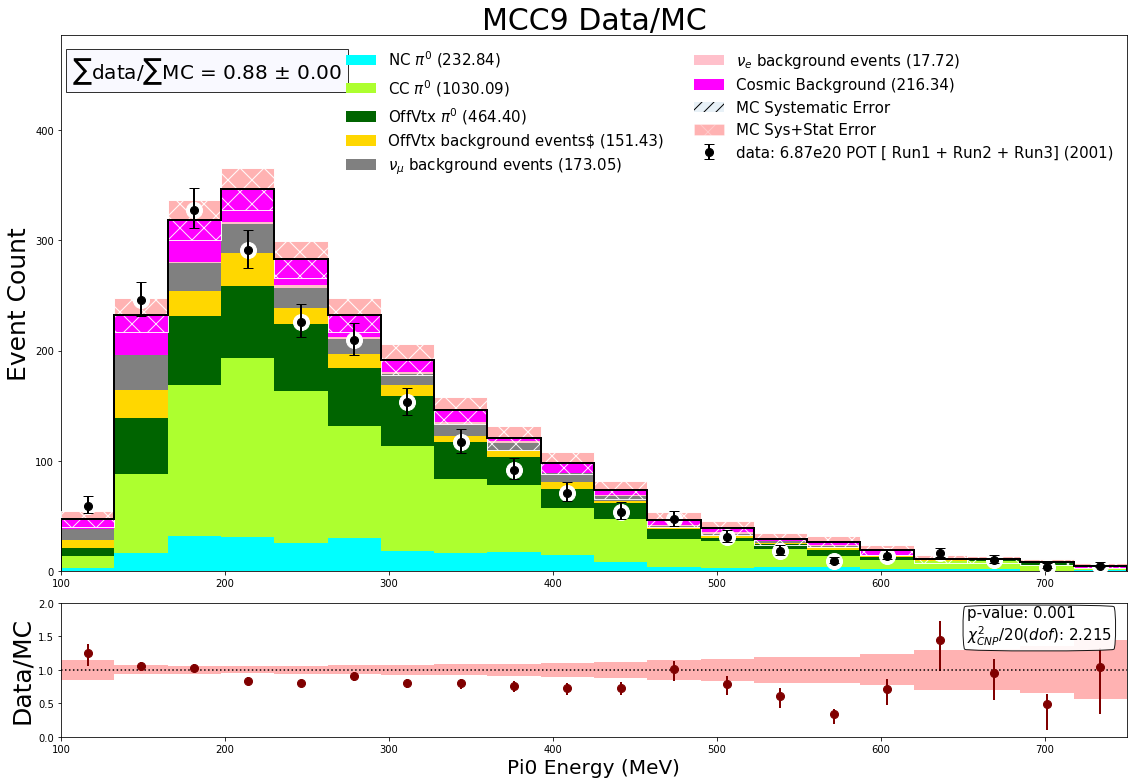

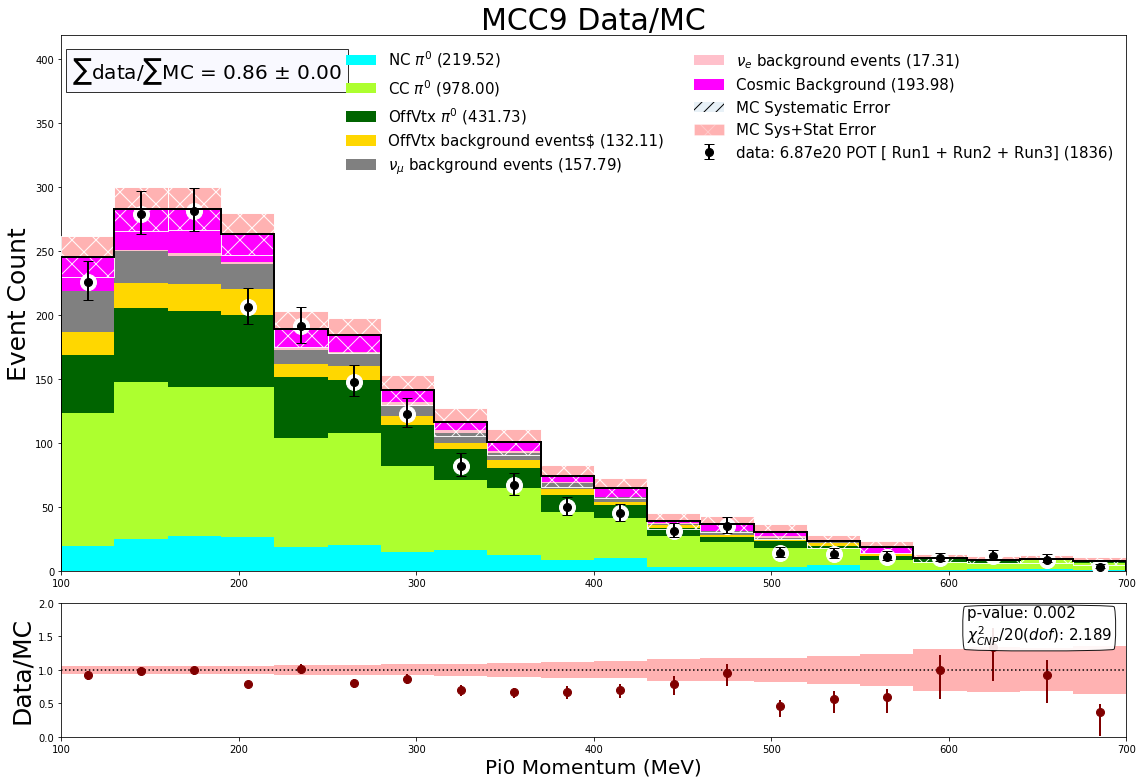

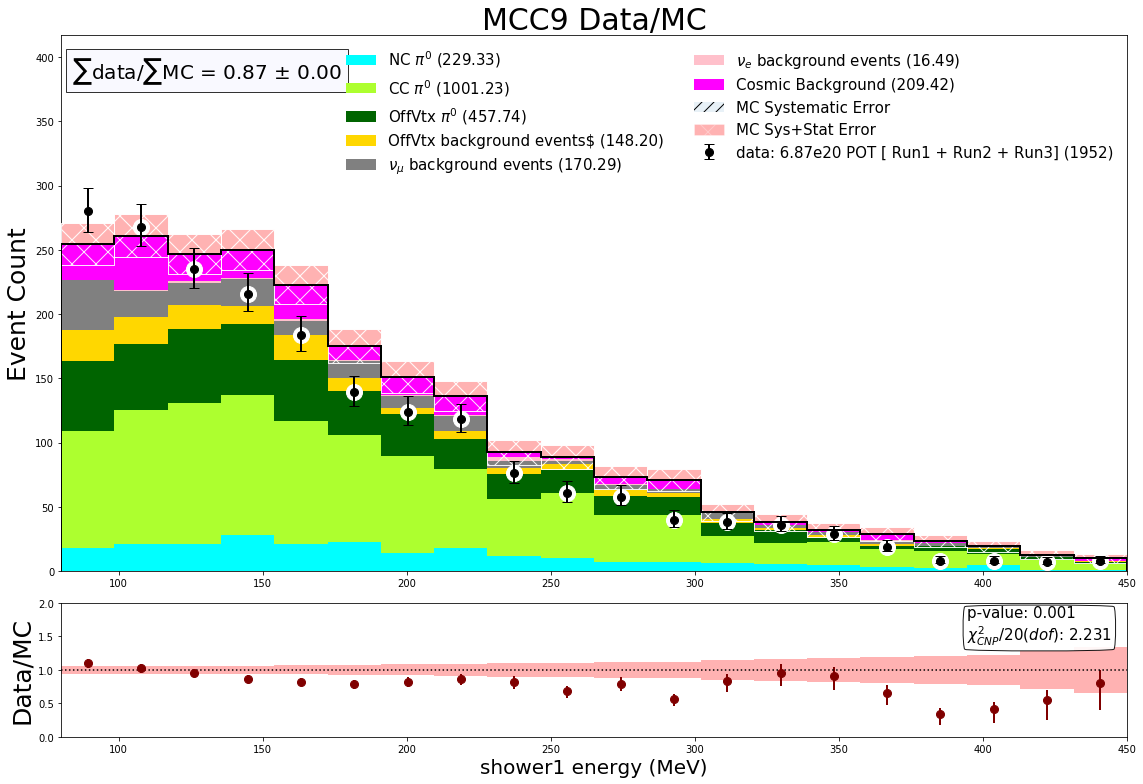

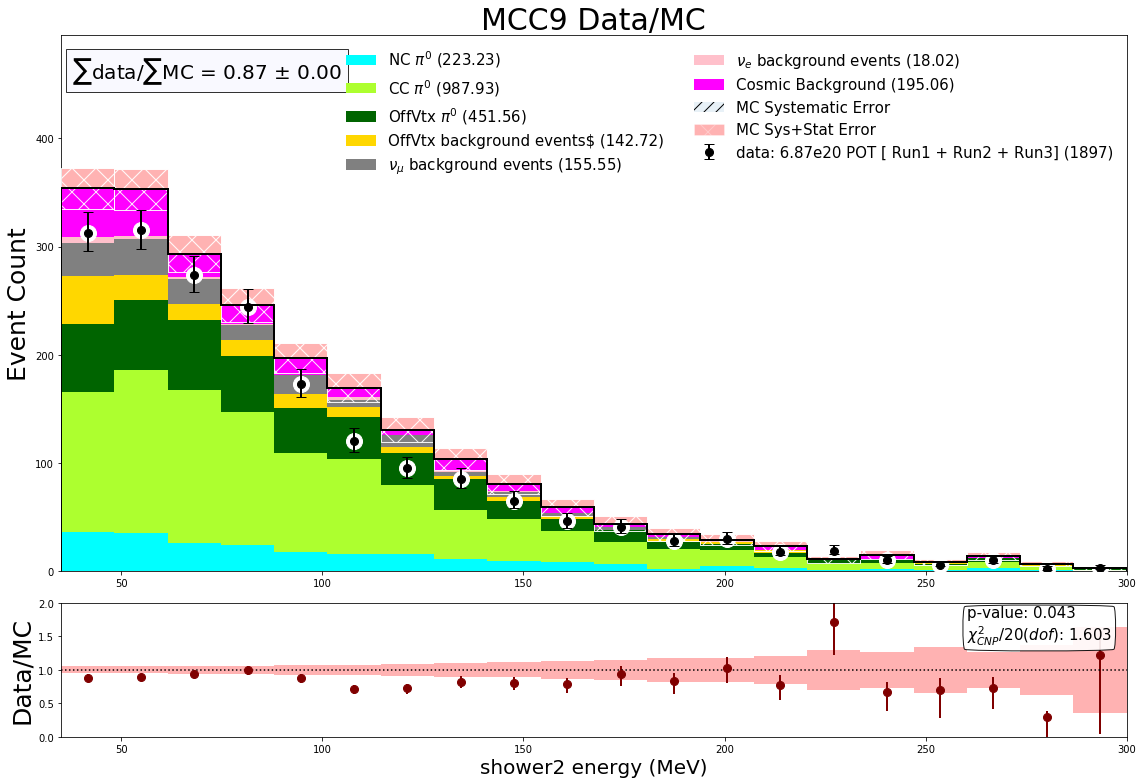

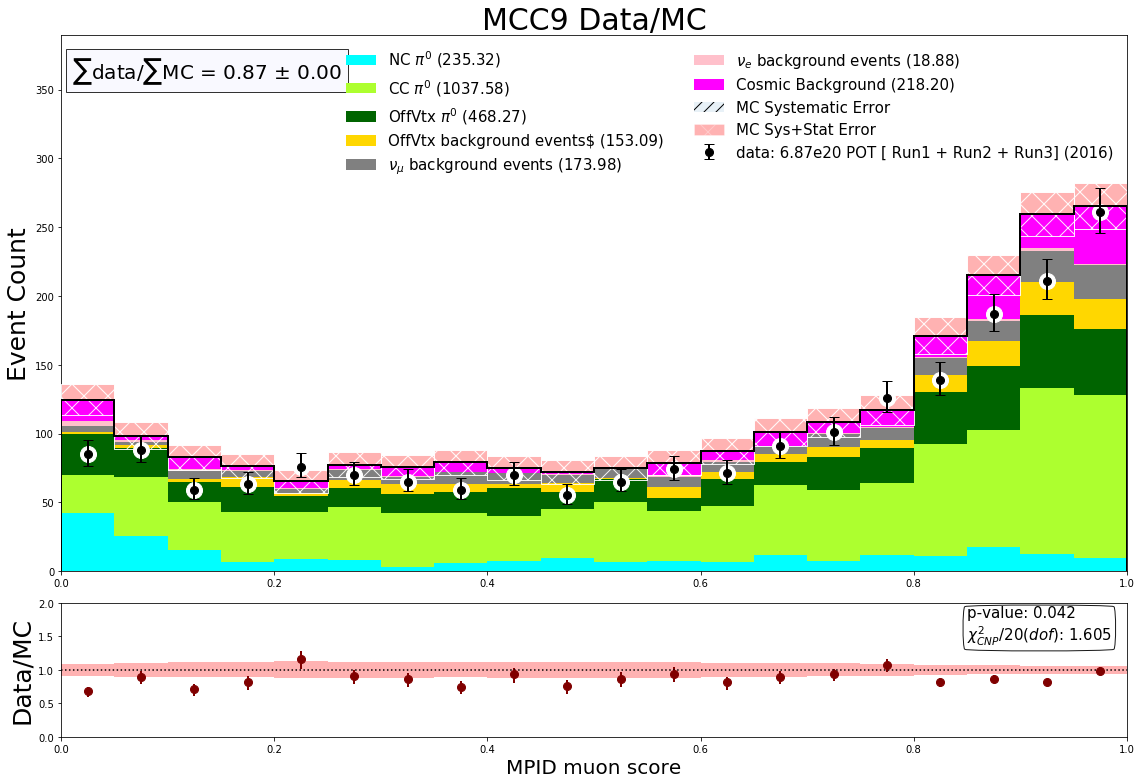

In [93]:
norm = 1.0
with PdfPages('output_combined_20210205_highstatsrun1.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        
#         if sys_list[i] == 'none':
#             s_cov = np.zeros((nbins,nbins))
#         else:
#             s_cov = np.genfromtxt(sys_list[i],delimiter=',')
        
#         if detvar_list[i] == 'none':
#             d_cov = np.zeros((nbins,nbins))
#         else:
#             d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
        
        cov = np.zeros((nbins,nbins))
        run1_open_Hists = StackedHisto((df_numu_total.query('(MC_parentPDG ==14) or MC_parentPDG ==-14'),df_nue_total.query('MC_parentPDG ==12')),(1.0,1.0,1.0,1.0))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx background events$",'gold')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"$\nu_\mu$ background events",'grey')
#         run1_open_Hists.AddStrata('MC_parentPDG ==14',r"$\nu_mu$ events",'blue')
        run1_open_Hists.AddStrata('MC_parentPDG ==12 and haspi0==0',r"$\nu_e$ background events",'pink')
        run1_open_Hists.AddLayer(df_ext_total,df_ext_total['pot_weight'],0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_total,1.0,0,'','data: 6.87e20 POT [ Run1 + Run2 + Run3]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
        pdf.savefig(fig1)

hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


/home/kmason/.local/lib/python3.5/site-packages/ipykernel_launcher.py:143: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kmason/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


hstack gh_weights [0.13061237 0.13061237 0.13061237 ... 0.27036854 0.27036854 0.27036854]
hstack gh_scale [1. 1. 1. ... 1. 1. 1.]


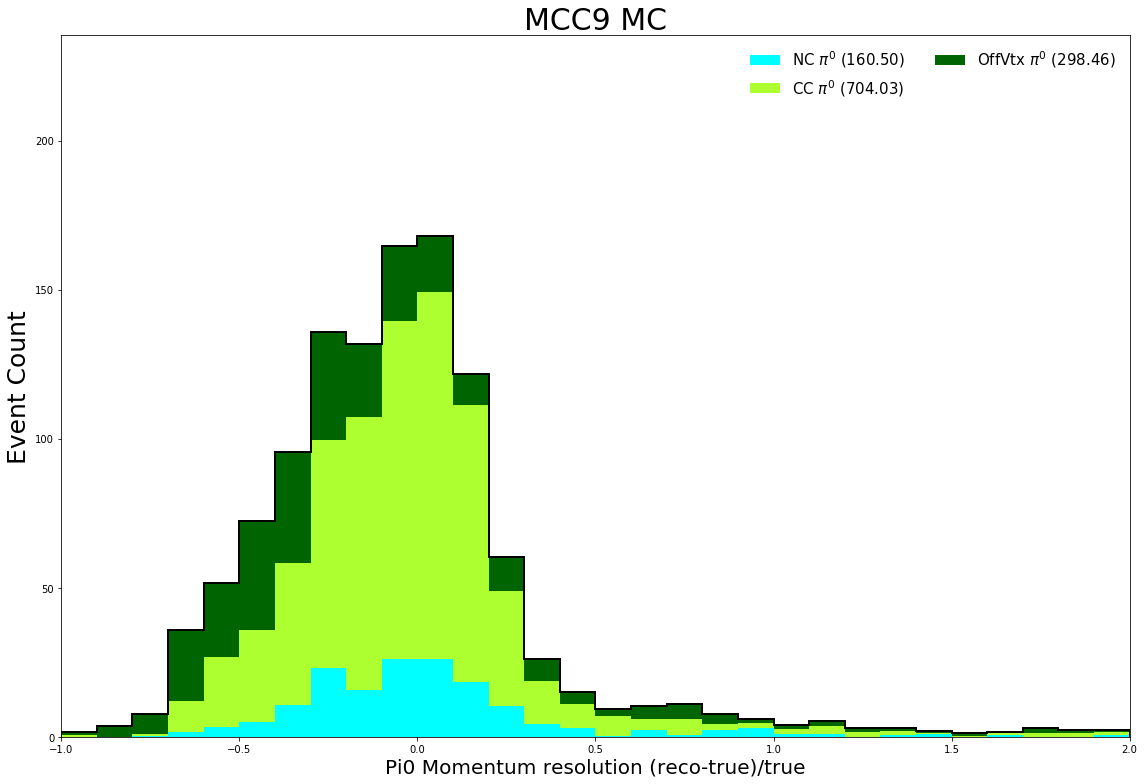

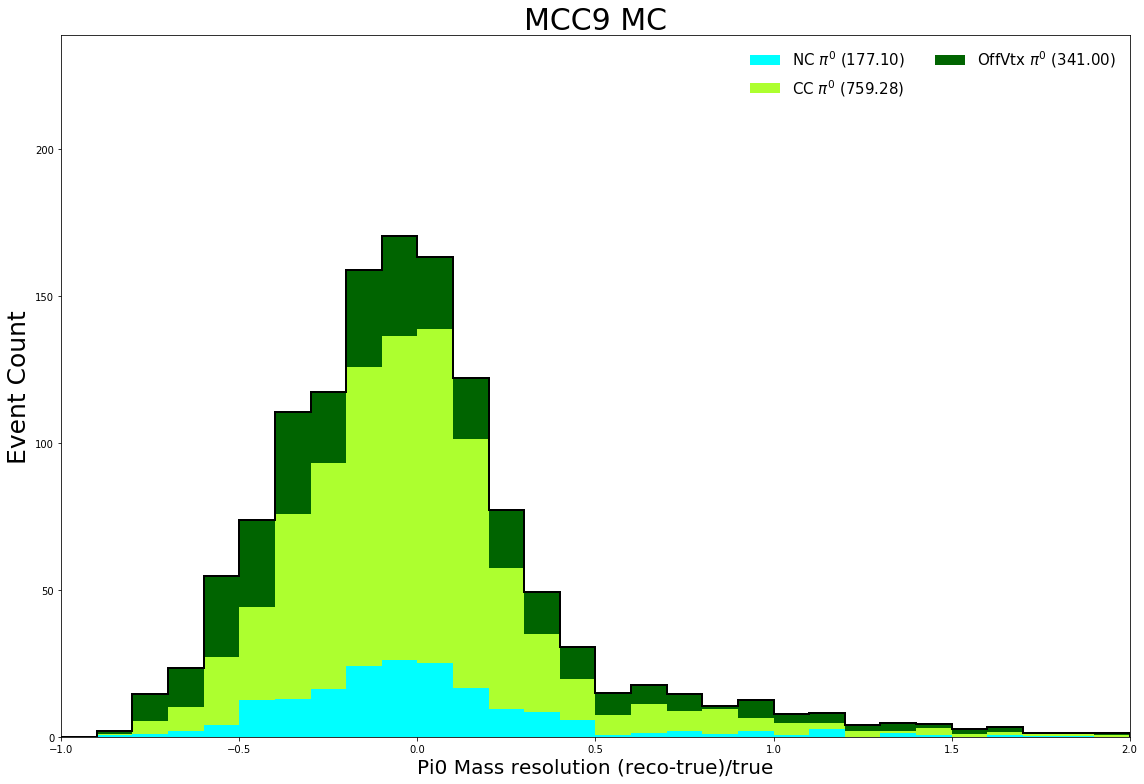

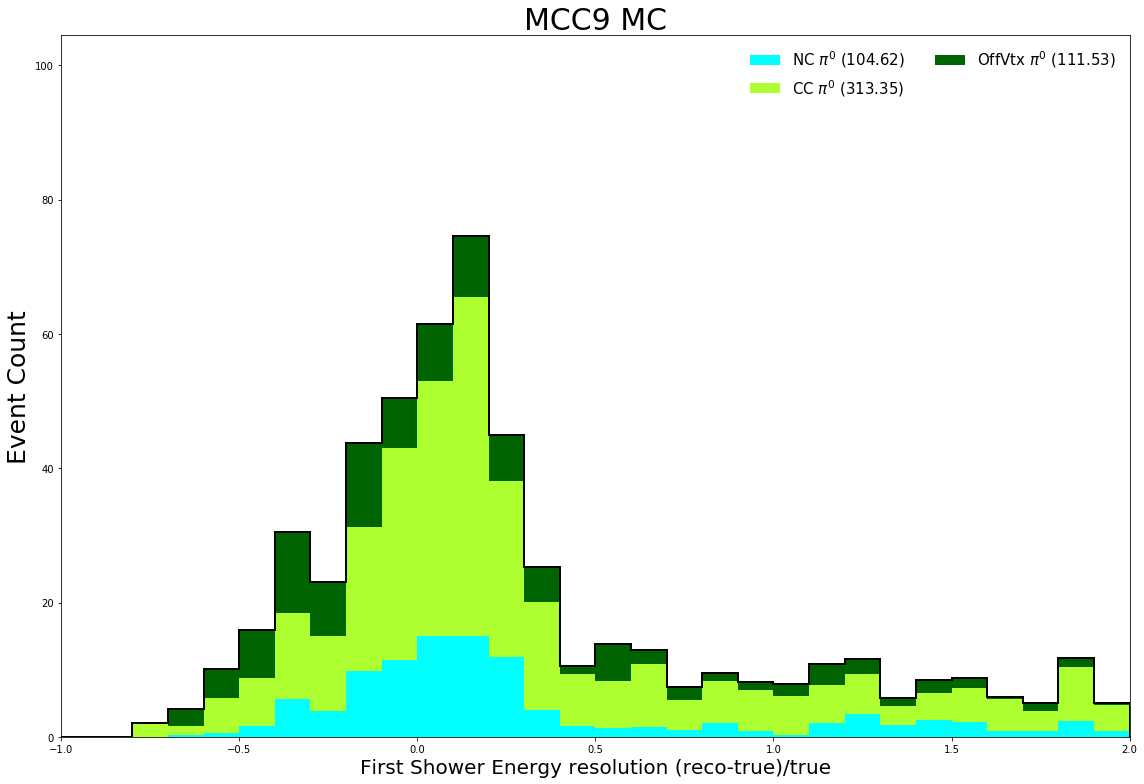

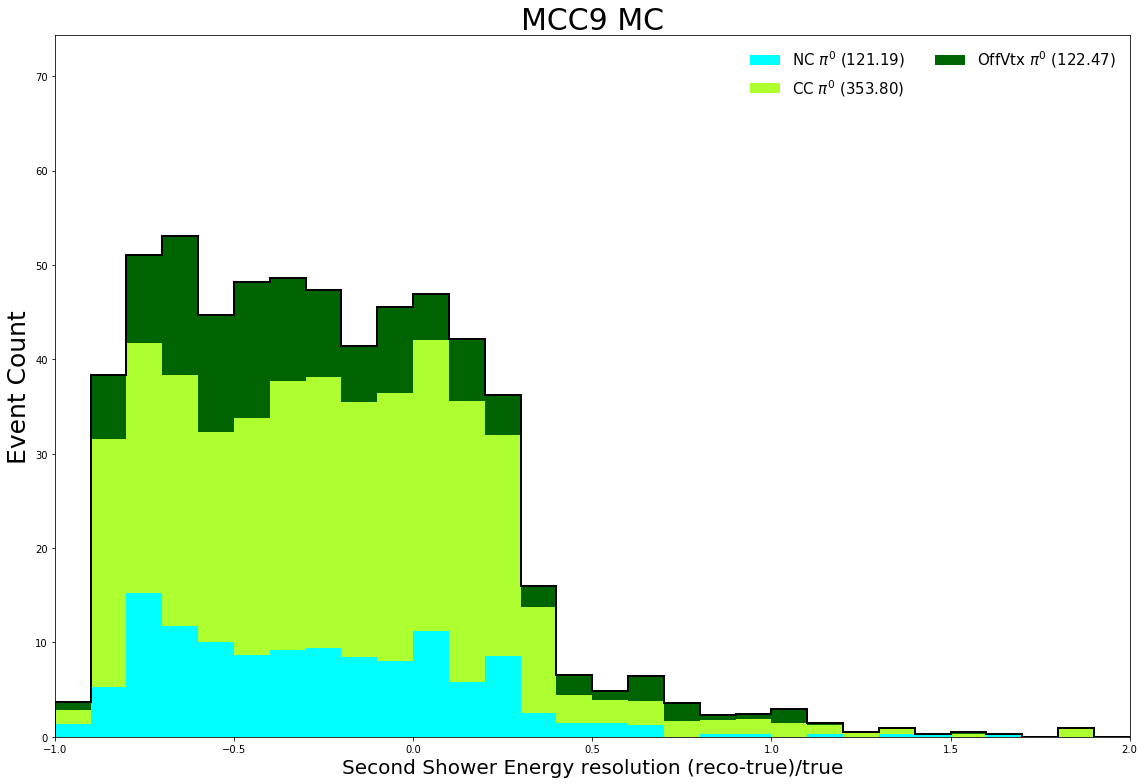

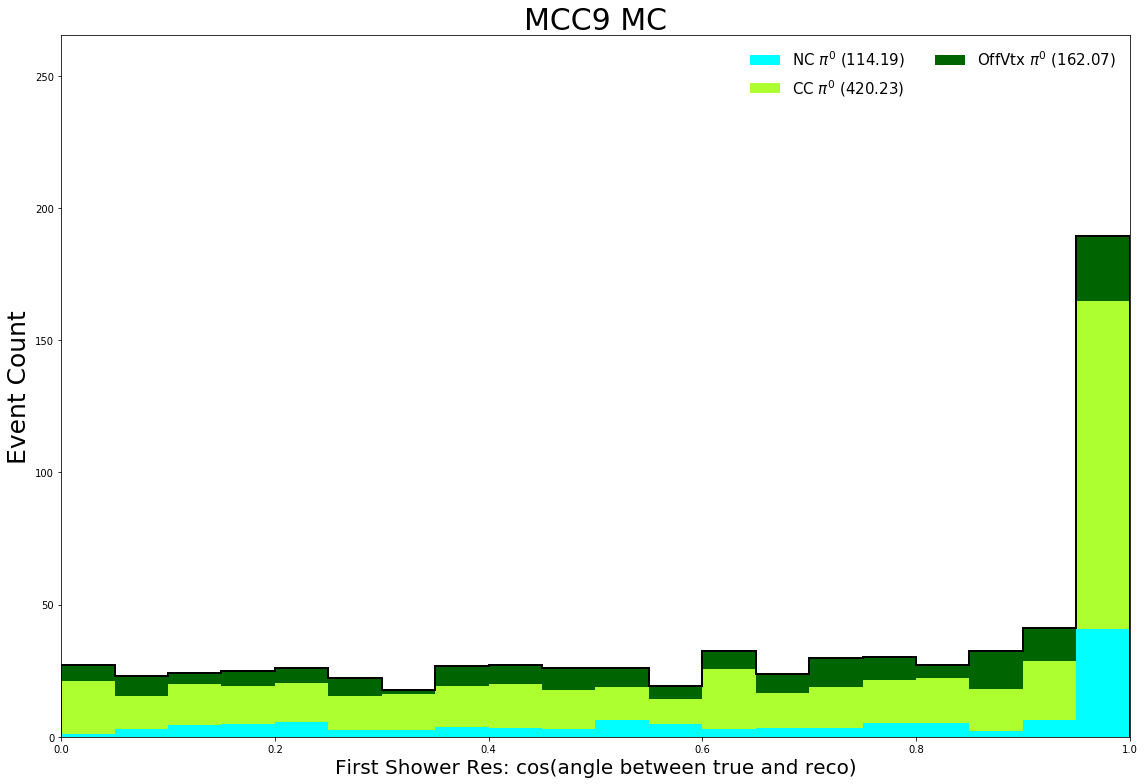

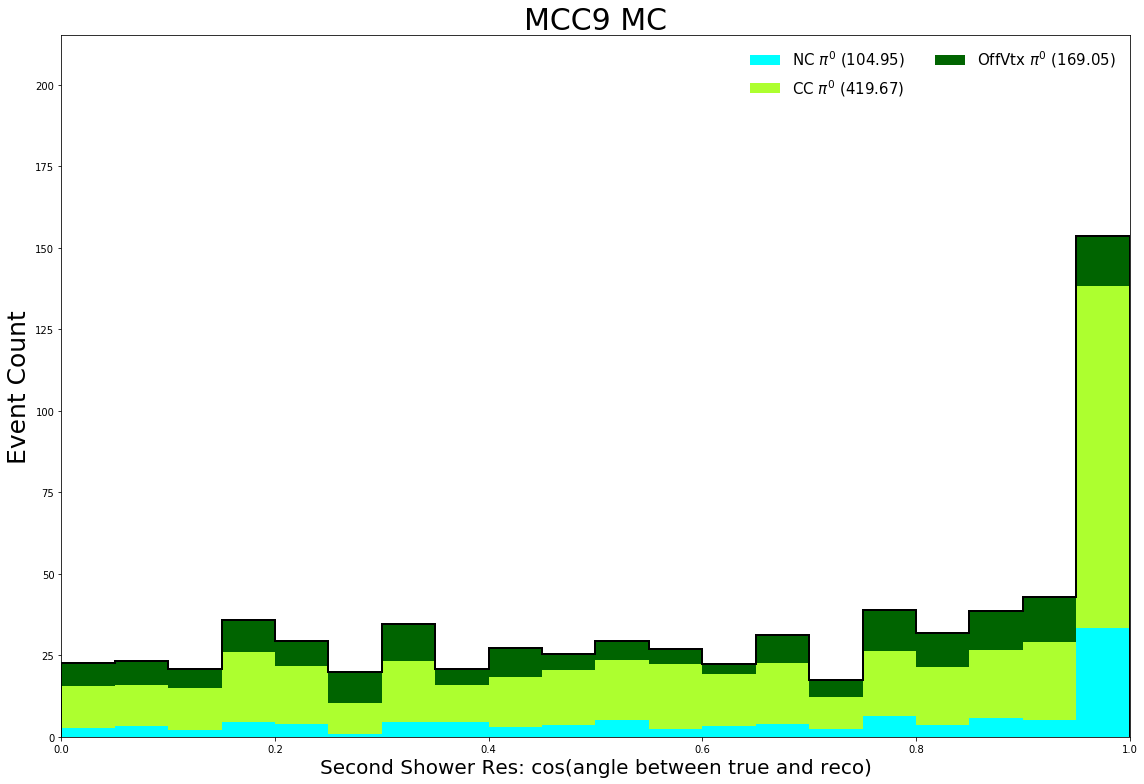

In [33]:
# plot all of the seperate pi0  distributions
vartest_list = []
varname_list = []
myrange_list = []
detvar_list  = []
sys_list = []
bins_list = []


vartest_list.append('Pi0MomentumRes')
varname_list.append('Pi0 Momentum resolution (reco-true)/true')
myrange_list.append((-1,2))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(30)

vartest_list.append('Pi0MassRes')
varname_list.append('Pi0 Mass resolution (reco-true)/true')
myrange_list.append((-1,2))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(30)

vartest_list.append('Pi0EnergyRes_1')
varname_list.append('First Shower Energy resolution (reco-true)/true')
myrange_list.append((-1,2))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(30)

vartest_list.append('Pi0EnergyRes_2')
varname_list.append('Second Shower Energy resolution (reco-true)/true')
myrange_list.append((-1,2))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(30)

vartest_list.append('Pi0AngleRes_1')
varname_list.append('First Shower Res: cos(angle between true and reco)')
myrange_list.append((0,1))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)


vartest_list.append('Pi0AngleRes_2')
varname_list.append('Second Shower Res: cos(angle between true and reco)')
myrange_list.append((0,1))
detvar_list.append('none')
sys_list.append('none')
bins_list.append(20)


norm = 1.0
with PdfPages('output_mcplots.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
       
        run1_open_Hists = StackedHisto((df_numu_total.query('MC_parentPDG ==14'),df_nue_total.query('MC_parentPDG ==12')),(1.0,1.0))
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
#         run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
#         run1_open_Hists.AddStrata('MC_parentPDG ==14 and haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
#         run1_open_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        fig1,ax1 = distplot_mc(vartest,nbins,myrange,run1_open_Hists,varname)
        pdf.savefig(fig1)

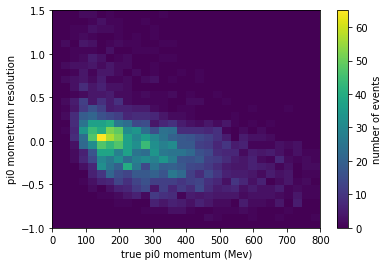

In [42]:
# make 2d hist:
import matplotlib

df_numu_total_haspi0 = df_numu_total.query('haspi0==1')
var_res =df_numu_total_haspi0['Pi0MomentumRes'].values
var_e =df_numu_total_haspi0['pi0_momentum_true'].values

plt.hist2d(var_e, var_res, bins=(30, 30), range = ((0,800),(-1,1.5)))
plt.xlabel('true pi0 momentum (Mev)')
plt.ylabel('pi0 momentum resolution')
plt.colorbar(label='number of events')

plt.show()



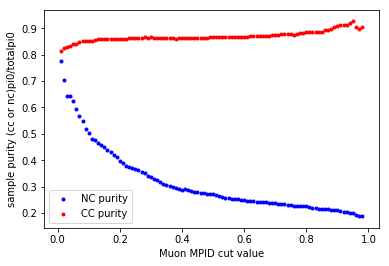

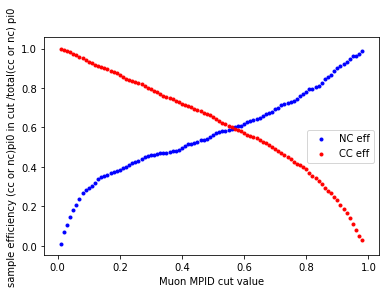

In [22]:
# choose mpid muon cut value

pur_NC = []
pur_CC = []
cutvals= [.01*i for i in range(1,99)]

eff_NC=[]
eff_CC=[]


for cut in cutvals:
    muoncut = str(cut)
    countcc=len(df_numu_total.query('haspi0 ==1 and ccnc==0 and MC_scedr<5 and MPID_muon >=' + muoncut))
    totalcc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and MPID_muon >=' + muoncut))
    countnc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and ccnc==1 and MPID_muon <' + muoncut))
    totalnc=len(df_numu_total.query('haspi0 ==1 and MC_scedr<5 and MPID_muon <' + muoncut))
    pur_CC.append(float(countcc)/float(totalcc))
    pur_NC.append(float(countnc)/float(totalnc))
    eff_CC.append(float(countcc)/float(len(df_numu_total.query('haspi0 ==1 and ccnc==0 and MC_scedr<5' ))))
    eff_NC.append(float(countnc)/float(len(df_numu_total.query('haspi0 ==1 and ccnc==1 and MC_scedr<5' ))))
    
plt.scatter(cutvals,pur_NC,color ='blue',label = "NC purity",marker='.')
plt.scatter(cutvals,pur_CC,color ='red',label = "CC purity",marker='.')
plt.legend()
plt.xlabel('Muon MPID cut value')
plt.ylabel('sample purity (cc or nc)pi0/totalpi0')
plt.show()
plt.close()

plt.scatter(cutvals,eff_NC,color ='blue',label = "NC eff",marker='.')
plt.scatter(cutvals,eff_CC,color ='red',label = "CC eff",marker='.')
plt.legend()
plt.xlabel('Muon MPID cut value')
plt.ylabel('sample efficiency (cc or nc)pi0 in cut /total(cc or nc) pi0')
plt.show()

In [23]:
def getweights(df):
    a = 2.161387253810258e-06
    b = -0.0029352304479204634
    c = 1.5171463693428389
    weights_v = []
    for i in range(len(df)):
        if df["haspi0"].values[i] ==1 :
            
            truemom = df["pi0_momentum_true"].values[i]
            if truemom<0:
                newweight = 1.0
            else:
                newweight = (a*(truemom**2)+b*truemom+c)
            weights_v.append(newweight)
        else: 
            weights_v.append(1.0)
    return weights_v

def resetweights(df):
    weights_v = []
    for i in range(len(df)):
        weights_v.append(1.0)
    return weights_v


vartest = '_pi0mass'
varname = r'$\pi^0$ mass (MeV)'
myrange = (0,400)
nbins = 20
norm = 1.0

#reset new weights column
ncpi0_new = resetweights(df_numu_total)
df_numu_total['new_weight'] = ncpi0_new
# now add in new weights
ncpi0_new = getweights(df_numu_total)
df_numu_total['new_weight'] = ncpi0_new


norm = 1.0
with PdfPages('output_combined_20201109_weighted.pdf') as pdf:

    for i in range(len(vartest_list)):
        vartest = vartest_list[i]
        varname = varname_list[i]
        myrange = myrange_list[i]
        nbins =bins_list[i]
        
        s_cov = np.genfromtxt(sys_list[i],delimiter=',')
        if detvar_list[i] == 'none':
            d_cov = np.zeros((nbins,nbins))
        else:
            d_cov = np.genfromtxt(detvar_list[i],delimiter=',')
        
        cov = s_cov +d_cov
        run1_open_Hists = StackedHisto((df_numu_total,df_nue_total),(NUMU_SCALE_TOTAL,NUE_SCALE_TOTAL))
        run1_open_Hists.AddStrata('haspi0==1 and ccnc==1 and MC_scedr<5 ',r"NC $\pi^0$",'cyan')
        run1_open_Hists.AddStrata('haspi0==1 and ccnc!=1 and MC_scedr<5 ',r"CC $\pi^0$",'greenyellow')
        run1_open_Hists.AddStrata('haspi0==1 and MC_scedr>=5 ',r"OffVtx $\pi^0$",'darkgreen')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr>=5 ',r"OffVtx non-$\pi^0$",'gold')
        run1_open_Hists.AddStrata('haspi0==0 and MC_scedr<5',r"good non-$\pi^0$",'grey')
        run1_open_Hists.AddStrata('MC_parentPDG ==12',r"$\nu_e$ events",'pink')
        run1_open_Hists.AddLayer(df_ext_total,df_ext_total['pot_weight'],0,'Cosmic Background','fuchsia')
        run1_open_DataHist = SimpleHisto(df_data_total,1.0,0,'','data: 6.87e20 POT [ Run1 + Run2 + Run3]')
        fig1,ax1,_,a = distplot_wratio_davio(vartest,nbins,myrange,run1_open_Hists,run1_open_DataHist,varname,m_cov=cov)
        pdf.savefig(fig1)

OSError: none not found.

QE count:  59
Res count:  3141
Dis count:  1242
Coh count:  5
MEC count:  6
[  0.  49. 309. 612. 649. 612. 490. 444. 341. 250. 186. 144.  90.  80.
  55.  36.  25.  28.  19.   4.] 4423.0
59
5
0


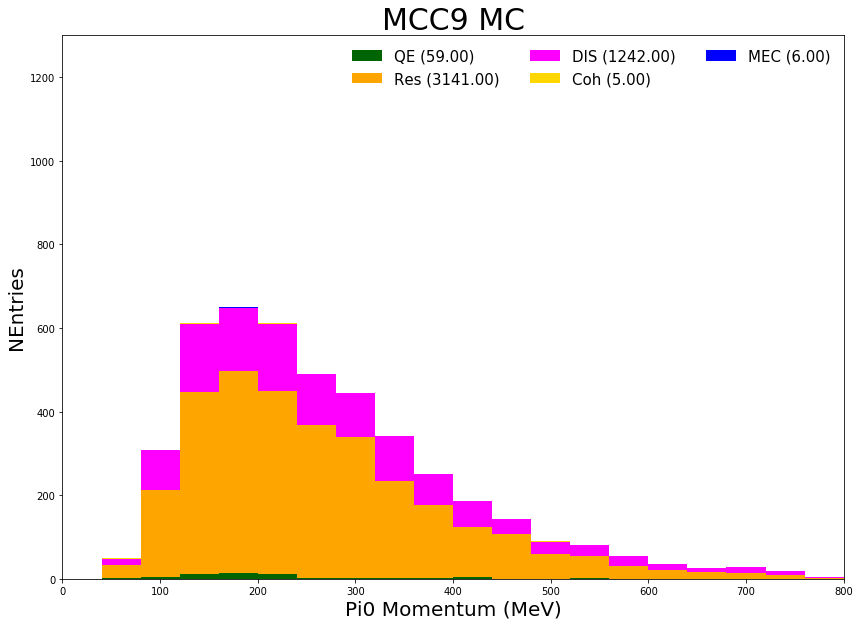

In [26]:
var_bnb_QE = df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Res = df_numu_total.query("nu_interaction_mode ==1 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Dis = df_numu_total.query("nu_interaction_mode ==2 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_Coh = df_numu_total.query("nu_interaction_mode ==3 and haspi0==1")['pi0_momentum_reco'].values
var_bnb_MEC = df_numu_total.query("nu_interaction_mode ==10 and haspi0==1")['pi0_momentum_reco'].values

print("QE count: ",len(df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")))
print("Res count: ",len(df_numu_total.query("nu_interaction_mode ==1 and haspi0==1")))
print("Dis count: ",len(df_numu_total.query("nu_interaction_mode ==2 and haspi0==1")))
print("Coh count: ",len(df_numu_total.query("nu_interaction_mode ==3 and haspi0==1")))
print("MEC count: ",len(df_numu_total.query("nu_interaction_mode ==10 and haspi0==1")))

fig,ax = plt.subplots(figsize=(14,10))
_hists=[var_bnb_QE,var_bnb_Res,var_bnb_Dis,var_bnb_Coh,var_bnb_MEC]
tmp_colors = ['darkgreen','orange','magenta','gold','blue']
myrange = (0,800)
nbins = 20
ymax =1300
tmp_labels = ['QE'+' (%.2f)'%len(var_bnb_QE),'Res'+' (%.2f)'%len(var_bnb_Res),'DIS'+' (%.2f)'%len(var_bnb_Dis),'Coh'+' (%.2f)'%len(var_bnb_Coh),'MEC'+' (%.2f)'%len(var_bnb_MEC)]

fig.patch.set_alpha(1)
vals_mc = np.zeros(nbins)

for i in range(0,len(_hists)):
    v1,binedges = np.histogram(_hists[i],nbins,range=myrange)
    vals_mc += v1

print (vals_mc, sum(vals_mc))


bincenters = np.diff(binedges)/2 + binedges[:-1]     

plt.ylim(0,ymax)
plt.xlim(myrange)
ax.set_xlabel("Pi0 Momentum (MeV)",fontsize=20)
ax.set_ylabel('NEntries',fontsize=20)
ax.set_title('MCC9 MC',fontsize=30)

plt.hist(_hists,nbins,range=myrange,color=tmp_colors,stacked=True,linewidth=2.5,label=tmp_labels,edgecolor='None')

ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

print(len(df_numu_total.query("nu_interaction_mode ==0 and haspi0==1")))
print(len(df_numu_total.query("nu_interaction_type ==1096 and haspi0==1")))
print(len(df_numu_total.query("nu_interaction_mode ==0 and nu_interaction_type ==1096 and haspi0==1 and MC_scedr<5")))

## Save selection for Lauren

In [39]:
def getpi0weights(df):
    a = 2.161387253810258e-06
    b = -0.0029352304479204634
    c = 1.5171463693428389

    weights =[]
    mom = df['pi0_momentum_true'].values
    pi0s = df['_pi0mass'].values
    for i in range(len(mom)):
        if pi0s[i] > 0 and a*(mom[i]**2)+b*mom[i]+c <4:
            weights.append(a*(mom[i]**2)+b*mom[i]+c)
        else:
            weights.append(1.0)
    return weights

weights1mu = getpi0weights(df_numu_pi0)
weights2mu = getpi0weights(df_numu_r2_pi0)
weights3mu = getpi0weights(df_numu_r3_pi0)
weights1e = getpi0weights(df_nue_pi0)
weights2e = getpi0weights(df_nue_r2_pi0)
weights3e = getpi0weights(df_nue_r3_pi0)
weights1cc = getpi0weights(df_ccpi0_r1_pi0)
weights3cc = getpi0weights(df_ccpi0_r3_pi0)
weights1nc = getpi0weights(df_ncpi0_r1_pi0)
weights3nc = getpi0weights(df_ncpi0_r3_pi0)

df_numu_pi0['pi0_weight']=weights1mu
df_numu_r2_pi0['pi0_weight']=weights2mu
df_numu_r3_pi0['pi0_weight']=weights3mu
df_nue_pi0['pi0_weight']=weights1e
df_nue_r2_pi0['pi0_weight']=weights2e
df_nue_r3_pi0['pi0_weight']=weights3e
df_ccpi0_r1_pi0['pi0_weight']=weights1cc
df_ccpi0_r3_pi0['pi0_weight']=weights3cc
df_ncpi0_r1_pi0['pi0_weight']=weights1nc
df_ncpi0_r3_pi0['pi0_weight']=weights3nc

In [40]:
df_numu_pi0=df_numu_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_pi0=df_nue_pi0.query("MC_parentPDG ==12")

file1 = open("2021Feb05_pi0selection_bnb_overlay_run1.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight]\n")
for event in range(len(df_numu_pi0)):
    teststr = "[" +str(df_numu_pi0['run'].values[event])+","+str(df_numu_pi0['subrun'].values[event])+","+str(df_numu_pi0['event'].values[event])+","+str(df_numu_pi0['_pi0mass_new'].values[event])+","+str(df_numu_pi0['DeltaMass_new'].values[event])
    teststr2 =","+ str(df_numu_pi0['shower1_E_Y_new'].values[event])+","+str(df_numu_pi0['shower2_E_Y_new'].values[event])+","+ str(df_numu_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_numu_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_numu_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021Feb05_pi0selection_nue_intrinsic_run1.txt","w")
file2.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight]\n")
for event in range(len(df_nue_pi0)):
    teststr = "[" +str(df_nue_pi0['run'].values[event])+","+str(df_nue_pi0['subrun'].values[event])+","+str(df_nue_pi0['event'].values[event])+","+str(df_nue_pi0['_pi0mass_new'].values[event])+","+str(df_nue_pi0['DeltaMass_new'].values[event])
    teststr2 =","+  str(df_nue_pi0['shower1_E_Y_new'].values[event])+","+str(df_nue_pi0['shower2_E_Y_new'].values[event])+","+ str(df_nue_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_nue_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_nue_pi0['pi0_weight'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()

file3 = open("2021Feb05_pi0selection_ext_run1.txt","w")
file3.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight]\n")
for event in range(len(df_ext_pi0)):
    teststr = "[" +str(df_ext_pi0['run'].values[event])+","+str(df_ext_pi0['subrun'].values[event])+","+str(df_ext_pi0['event'].values[event])+","+str(df_ext_pi0['_pi0mass_new'].values[event])+","+str(df_ext_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ext_pi0['shower1_E_Y_new'].values[event])+","+str(df_ext_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ext_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ext_pi0['pi0_momentum_reco'].values[event])+","+'1.0'+"]"+"\n"
    file3.write(teststr+teststr2)
file3.close()


In [41]:
df_numu_r2_pi0=df_numu_r2_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_r2_pi0=df_nue_r2_pi0.query("MC_parentPDG ==12")

file1 = open("2021Feb05_pi0selection_bnb_overlay_run2.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight, true neutrino energy]\n")
for event in range(len(df_numu_r2_pi0)):
    teststr = "[" +str(df_numu_r2_pi0['run'].values[event])+","+str(df_numu_r2_pi0['subrun'].values[event])+","+str(df_numu_r2_pi0['event'].values[event])+","+str(df_numu_r2_pi0['_pi0mass_new'].values[event])+","+str(df_numu_r2_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_numu_r2_pi0['shower1_E_Y_new'].values[event])+","+str(df_numu_r2_pi0['shower2_E_Y_new'].values[event])+","+ str(df_numu_r2_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_numu_r2_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_numu_r2_pi0['pi0_weight'].values[event])+","+ str(df_numu_r2_pi0['nu_energy_true'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021Feb05_pi0selection_nue_intrinsic_run2.txt","w")
file2.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight]\n")
for event in range(len(df_nue_r2_pi0)):
    teststr = "[" +str(df_nue_r2_pi0['run'].values[event])+","+str(df_nue_r2_pi0['subrun'].values[event])+","+str(df_nue_r2_pi0['event'].values[event])+","+str(df_nue_r2_pi0['_pi0mass_new'].values[event])+","+str(df_nue_r2_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_nue_r2_pi0['shower1_E_Y_new'].values[event])+","+str(df_nue_r2_pi0['shower2_E_Y_new'].values[event])+","+ str(df_nue_r2_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_nue_r2_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_nue_r2_pi0['pi0_weight'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()


In [42]:
df_numu_r3_pi0=df_numu_r3_pi0.query('(MC_parentPDG ==14  and newhaspi0==0) or MC_parentPDG ==-14')
df_nue_r3_pi0=df_nue_r3_pi0.query("MC_parentPDG ==12")

file1 = open("2021Feb05_pi0selection_bnb_overlay_run3.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_numu_r3_pi0)):
    teststr = "[" +str(df_numu_r3_pi0['run'].values[event])+","+str(df_numu_r3_pi0['subrun'].values[event])+","+str(df_numu_r3_pi0['event'].values[event])+","+str(df_numu_r3_pi0['_pi0mass_new'].values[event])+","+str(df_numu_r3_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_numu_r3_pi0['shower1_E_Y_new'].values[event])+","+str(df_numu_r3_pi0['shower2_E_Y_new'].values[event])+","+ str(df_numu_r3_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_numu_r3_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_numu_r3_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()


file2 = open("2021Feb05_pi0selection_nue_intrinsic_run3.txt","w")
file2.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_nue_r3_pi0)):
    teststr = "[" +str(df_nue_r3_pi0['run'].values[event])+","+str(df_nue_r3_pi0['subrun'].values[event])+","+str(df_nue_r3_pi0['event'].values[event])+","+str(df_nue_r3_pi0['_pi0mass_new'].values[event])+","+str(df_nue_r3_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_nue_r3_pi0['shower1_E_Y_new'].values[event])+","+str(df_nue_r3_pi0['shower2_E_Y_new'].values[event])+","+ str(df_nue_r3_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_nue_r3_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_nue_r3_pi0['pi0_weight'].values[event])+"]"+"\n"
    file2.write(teststr+teststr2)
file2.close()

file3 = open("2021Feb05_pi0selection_ext_run3.txt","w")
file3.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum, weight]\n")
for event in range(len(df_ext_r3_pi0)):
    teststr = "[" +str(df_ext_r3_pi0['run'].values[event])+","+str(df_ext_r3_pi0['subrun'].values[event])+","+str(df_ext_r3_pi0['event'].values[event])+","+str(df_ext_r3_pi0['_pi0mass_new'].values[event])+","+str(df_ext_r3_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ext_r3_pi0['shower1_E_Y_new'].values[event])+","+str(df_ext_r3_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ext_r3_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ext_r3_pi0['pi0_momentum_reco_new'].values[event])+","+'1.0'+"]"+"\n"
    file3.write(teststr+teststr2)
file3.close()

In [43]:
file1 = open("2021Feb05_pi0selection_CCPi0_run1.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_ccpi0_r1_pi0)):
    teststr = "[" +str(df_ccpi0_r1_pi0['run'].values[event])+","+str(df_ccpi0_r1_pi0['subrun'].values[event])+","+str(df_ccpi0_r1_pi0['event'].values[event])+","+str(df_ccpi0_r1_pi0['_pi0mass_new'].values[event])+","+str(df_ccpi0_r1_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ccpi0_r1_pi0['shower1_E_Y_new'].values[event])+","+str(df_ccpi0_r1_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ccpi0_r1_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ccpi0_r1_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_ccpi0_r1_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()

file1 = open("2021Feb05_pi0selection_CCPi0_run3.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_ccpi0_r3_pi0)):
    teststr = "[" +str(df_ccpi0_r3_pi0['run'].values[event])+","+str(df_ccpi0_r3_pi0['subrun'].values[event])+","+str(df_ccpi0_r3_pi0['event'].values[event])+","+str(df_ccpi0_r3_pi0['_pi0mass_new'].values[event])+","+str(df_ccpi0_r3_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ccpi0_r3_pi0['shower1_E_Y_new'].values[event])+","+str(df_ccpi0_r3_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ccpi0_r3_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ccpi0_r3_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_ccpi0_r3_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()



In [44]:
file1 = open("2021Feb05_pi0selection_NCPi0_run1.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_ncpi0_r1_pi0)):
    teststr = "[" +str(df_ncpi0_r1_pi0['run'].values[event])+","+str(df_ncpi0_r1_pi0['subrun'].values[event])+","+str(df_ncpi0_r1_pi0['event'].values[event])+","+str(df_ncpi0_r1_pi0['_pi0mass_new'].values[event])+","+str(df_ncpi0_r1_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ncpi0_r1_pi0['shower1_E_Y_new'].values[event])+","+str(df_ncpi0_r1_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ncpi0_r1_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ncpi0_r1_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_ncpi0_r1_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()

file1 = open("2021Feb05_pi0selection_NCPi0_run3.txt","w")
file1.write("[run,subrun,event,pi0mass, deltamass, shower1_energy, shower2_energy, pi0energy, pi0momentum,weight]\n")
for event in range(len(df_ncpi0_r3_pi0)):
    teststr = "[" +str(df_ncpi0_r3_pi0['run'].values[event])+","+str(df_ncpi0_r3_pi0['subrun'].values[event])+","+str(df_ncpi0_r3_pi0['event'].values[event])+","+str(df_ncpi0_r3_pi0['_pi0mass_new'].values[event])+","+str(df_ncpi0_r3_pi0['DeltaMass_new'].values[event])
    teststr2 = ","+ str(df_ncpi0_r3_pi0['shower1_E_Y_new'].values[event])+","+str(df_ncpi0_r3_pi0['shower2_E_Y_new'].values[event])+","+ str(df_ncpi0_r3_pi0['pi0_energy_reco_new'].values[event])+","+ str(df_ncpi0_r3_pi0['pi0_momentum_reco_new'].values[event])+","+ str(df_ncpi0_r3_pi0['pi0_weight'].values[event])+"]"+"\n"
    file1.write(teststr+teststr2)
file1.close()
